# Curriculum Designer evaluation experiments

This notebook contains all the experiments from the evaluation of our proposed curriculum designers, OTF-last and OTF-avg.
This notebook contains the following components, each containing a subsection for the 5-task setting and the longer settings.

0. Helper funtions
1. Evaluation of CD performance
2. Evolution of CD performance
3. Stability of task orders from OTF CDs

## 0. Helper Functions

In [1]:
# config
five_task_datasets = ["CIFAR10", "CIFAR10-random", "M2I"]
longer_datasets = ["CIFAR100", "CIFAR100-superclass", "TinyImageNet"]
dataset_to_name = {"CIFAR10": "CIFAR10-I", "CIFAR10-random": "CIFAR10-II", "M2I": "M2I", "CIFAR100": "CIFAR100", "CIFAR100-superclass": "CIFAR100-superclass", "TinyImageNet": "TinyImageNet"}

strategies = ["replay", "mir", "gss", "cope"]
strategy_to_name = {"replay": "ER", "mir": "MIR", "gss": "GSS", "cope": "CoPE"}

five_task_cds = ["on the fly-center-max-false", "on the fly-center-max-true", "random", "L2L"]
longer_cds = ["on the fly-center-max-false", "on the fly-center-max-true", "random"]
cd_to_name = {"random": "Random", "L2L": "L2L", "on the fly-center-max-false": "OTF-last", "on the fly-center-max-true": "OTF-avg"}

In [2]:
import json
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def load_results(dataset, strategy, cd):
    if dataset in ["CIFAR10", "CIFAR10-random", "M2I"]:
        num_classes = 10
        classes_per_task = 2
    elif dataset in ["CIFAR100", "CIFAR100-superclass"]:
        num_classes = 100
        classes_per_task = 5
    elif dataset == "TinyImageNet":
        num_classes = 200
        classes_per_task = 5
    if dataset == "M2I" and cd == "random":
        num_classes = 100
        classes_per_task = 5
    if dataset in ["CIFAR10", "CIFAR10-random", "M2I"]:
        with open(f"logs/cd_comparison/{cd}-strategy-{strategy}-dataset-{dataset}-{num_classes}-False-{classes_per_task}.json") as f:
            return json.load(f)
    else:
        with open(f"logs/cd_comparison/{cd}-strategy-{strategy}-dataset-{dataset}-{num_classes}-False-{classes_per_task}-5000.json") as f:
            return json.load(f)
        
def spearman_footrule_distance(permutation1, permutation2):
    # Check if the input permutations have the same length
    if len(permutation1) != len(permutation2):
        raise ValueError("Permutations must have the same length")

    distance = 0

    for idx1, element in enumerate(permutation1):
        idx2 = permutation2.index(element)
        distance += abs(idx1 - idx2)
    return distance

## 1. Evaluation of CD performance

### 5-task settings

In [3]:
df_data = []
df_data_std = []
for dataset in five_task_datasets:
    for cd in five_task_cds:
        average_accuracies = []
        for strategy in strategies:
            result_dict = load_results(dataset, strategy, cd)
            final_avg_acc = np.mean(result_dict["accuracy"], axis=0)[-1]
            average_accuracies.append(final_avg_acc)
            df_entry = {"Dataset": dataset_to_name[dataset], "CD": cd_to_name[cd], "strategy": strategy_to_name[strategy], "value": final_avg_acc}
            df_data.append(df_entry)
            df_data_std.append({"Dataset": dataset_to_name[dataset], "CD": cd_to_name[cd], "strategy": strategy_to_name[strategy], "value": np.std(result_dict["accuracy"], axis=0)[-1]})
df = pd.DataFrame(df_data)
df_std = pd.DataFrame(df_data_std)
df = df.pivot_table(index=['Dataset', 'strategy'], columns='CD', values='value', aggfunc='last').reset_index().round(3)
df_std = df_std.pivot_table(index=['Dataset', 'strategy'], columns='CD', values='value', aggfunc='last').reset_index().round(3)
df_std = df_std[["Dataset","strategy", "Random", "L2L","OTF-last","OTF-avg"]]
df_std.to_csv(f"results/cd_evaluation/evaluation_cd_performance/5-task-datasets-full_results_std.csv", index=False)
df = df[["Dataset","strategy", "Random", "L2L","OTF-last","OTF-avg"]]
df.to_csv(f"results/cd_evaluation/evaluation_cd_performance/5-task-datasets-full_results.csv", index=False)

#### Statistical significance

In [4]:
df_acc_data = []
df_stat_data = []

for dataset in five_task_datasets:
    for strategy in strategies:
        df_acc_entry = {"Dataset": dataset_to_name[dataset], "Strategy": strategy_to_name[strategy]}
        df_stat_entry = {"Dataset": dataset_to_name[dataset], "Strategy": strategy_to_name[strategy]}

        otf_last_results = load_results(dataset, strategy, cd="on the fly-center-max-false")
        otf_avg_results = load_results(dataset, strategy, cd="on the fly-center-max-true")
        random_perm_results = load_results(dataset, strategy, cd="random")
        l2l_results = load_results(dataset, strategy, cd="L2L")
        
        l2l_final_avg_accuracy = np.mean(l2l_results["accuracy"], axis=0)[-1]
        df_acc_entry["L2L"] = l2l_final_avg_accuracy
        otf_last_final_avg_accuracy = np.mean(otf_last_results["accuracy"], axis=0)[-1]
        df_acc_entry["OTF-last"] = otf_last_final_avg_accuracy
        otf_avg_final_avg_accuracy = np.mean(otf_avg_results["accuracy"], axis=0)[-1]
        df_acc_entry["OTF-avg"] = otf_avg_final_avg_accuracy
        random_perm_final_avg_accuracy = np.mean(random_perm_results["accuracy"], axis=0)[-1]
        df_acc_entry["Random"] = random_perm_final_avg_accuracy
        df_acc_data.append(df_acc_entry)

        t_statistic_L2L_random, p_value_L2L_random = stats.ttest_ind(np.array(l2l_results["accuracy"])[:, -1], np.array(random_perm_results["accuracy"])[:, -1])
        t_statistic_otf_last_random, p_value_otf_last_random = stats.ttest_ind(np.array(otf_last_results["accuracy"])[:, -1], np.array(random_perm_results["accuracy"])[:, -1])
        t_statistic_otf_avg_random, p_value_otf_avg_random = stats.ttest_ind(np.array(otf_avg_results["accuracy"])[:, -1], np.array(random_perm_results["accuracy"])[:, -1])
        
        df_stat_entry["L2L - Random p-value"] = p_value_L2L_random
        df_stat_entry["OTF-last - Random p-value"] = p_value_otf_last_random
        df_stat_entry["OTF-avg - Random p-value"] = p_value_otf_avg_random
        df_stat_data.append(df_stat_entry)
df_stat = pd.DataFrame(df_stat_data).round(3)
df_stat.to_csv("results/cd_evaluation/evaluation_cd_performance/5-task-datasets-p-values.csv")
df_stat

Dataset Strategy  L2L - Random p-value  OTF-last - Random p-value  \
0    CIFAR10-I       ER                 0.032                      0.960   
1    CIFAR10-I      MIR                 0.342                      0.000   
2    CIFAR10-I      GSS                 0.000                      0.335   
3    CIFAR10-I     CoPE                 0.929                      0.032   
4   CIFAR10-II       ER                 0.096                      0.988   
5   CIFAR10-II      MIR                 0.614                      0.505   
6   CIFAR10-II      GSS                 0.019                      0.547   
7   CIFAR10-II     CoPE                 0.125                      0.586   
8          M2I       ER                 0.370                      0.000   
9          M2I      MIR                 0.149                      0.060   
10         M2I      GSS                 0.065                      0.295   
11         M2I     CoPE                 0.939                      0.011   

    OTF-avg - Random p-value  
0                      0.451  
1                      0.037  
2                      0.267  
3                      0.082  
4                      0.583  
5                      0.761  
6                      0.040  
7                      0.894  
8                      0.000  
9                      0.205  
10                     0.281  
11                     0.014

### Longer settings

In [5]:
df_data = []
df_data_std = []
for dataset in longer_datasets:
    for cd in longer_cds:
        average_accuracies = []
        for strategy in strategies:
            result_dict = load_results(dataset, strategy, cd)
            final_avg_acc = np.mean(result_dict["accuracy"], axis=0)[-1]
            average_accuracies.append(final_avg_acc)
            df_entry = {"Dataset": dataset_to_name[dataset], "CD": cd_to_name[cd], "strategy": strategy_to_name[strategy], "value": final_avg_acc}
            df_data.append(df_entry)
            df_data_std.append({"Dataset": dataset_to_name[dataset], "CD": cd_to_name[cd], "strategy": strategy_to_name[strategy], "value": np.std(result_dict["accuracy"], axis=0)[-1]})
df = pd.DataFrame(df_data)
df_std = pd.DataFrame(df_data_std)
df = df.pivot_table(index=['Dataset', 'strategy'], columns='CD', values='value', aggfunc='last').reset_index().round(3)
df_std = df_std.pivot_table(index=['Dataset', 'strategy'], columns='CD', values='value', aggfunc='last').reset_index().round(3)
df_std = df_std[["Dataset","strategy", "Random","OTF-last","OTF-avg"]]
df_std.to_csv(f"results/cd_evaluation/evaluation_cd_performance/longer-datasets-full_results_std.csv", index=False)
df = df[["Dataset","strategy", "Random","OTF-last","OTF-avg"]]
df.to_csv(f"results/cd_evaluation/evaluation_cd_performance/longer-datasets-full_results.csv", index=False)

#### Statistical significance

In [6]:
df_acc_data = []
df_stat_data = []

for dataset in longer_datasets:
    for strategy in strategies:
        df_acc_entry = {"Dataset": dataset_to_name[dataset], "Strategy": strategy_to_name[strategy]}
        df_stat_entry = {"Dataset": dataset_to_name[dataset], "Strategy": strategy_to_name[strategy]}

        otf_last_results = load_results(dataset, strategy, cd="on the fly-center-max-false")
        otf_avg_results = load_results(dataset, strategy, cd="on the fly-center-max-true")
        random_perm_results = load_results(dataset, strategy, cd="random")
        
        otf_last_final_avg_accuracy = np.mean(otf_last_results["accuracy"], axis=0)[-1]
        df_acc_entry["OTF-last"] = otf_last_final_avg_accuracy
        otf_avg_final_avg_accuracy = np.mean(otf_avg_results["accuracy"], axis=0)[-1]
        df_acc_entry["OTF-avg"] = otf_avg_final_avg_accuracy
        random_perm_final_avg_accuracy = np.mean(random_perm_results["accuracy"], axis=0)[-1]
        df_acc_entry["Random"] = random_perm_final_avg_accuracy
        df_acc_data.append(df_acc_entry)

        t_statistic_otf_last_random, p_value_otf_last_random = stats.ttest_ind(np.array(otf_last_results["accuracy"])[:, -1], np.array(random_perm_results["accuracy"])[:, -1])
        t_statistic_otf_avg_random, p_value_otf_avg_random = stats.ttest_ind(np.array(otf_avg_results["accuracy"])[:, -1], np.array(random_perm_results["accuracy"])[:, -1])
        
        df_stat_entry["OTF-last - Random p-value"] = p_value_otf_last_random
        df_stat_entry["OTF-avg - Random p-value"] = p_value_otf_avg_random
        df_stat_data.append(df_stat_entry)
df_stat = pd.DataFrame(df_stat_data).round(3)
df_stat.to_csv("results/cd_evaluation/evaluation_cd_performance/longer-datasets-p-values.csv")
df_stat

Dataset Strategy  OTF-last - Random p-value  \
0              CIFAR100       ER                      0.342   
1              CIFAR100      MIR                      0.541   
2              CIFAR100      GSS                      0.008   
3              CIFAR100     CoPE                      0.025   
4   CIFAR100-superclass       ER                      0.048   
5   CIFAR100-superclass      MIR                      0.014   
6   CIFAR100-superclass      GSS                      0.364   
7   CIFAR100-superclass     CoPE                      0.001   
8          TinyImageNet       ER                      0.795   
9          TinyImageNet      MIR                      0.334   
10         TinyImageNet      GSS                      0.461   
11         TinyImageNet     CoPE                      0.002   

    OTF-avg - Random p-value  
0                      0.741  
1                      0.604  
2                      0.001  
3                      0.028  
4                      0.081  
5                      0.052  
6                      0.018  
7                      0.014  
8                      0.610  
9                      0.212  
10                     0.499  
11                     0.000

## 2. Evolution of CD performance

### 5-taks settings

#### Evolution of incremental accuracy

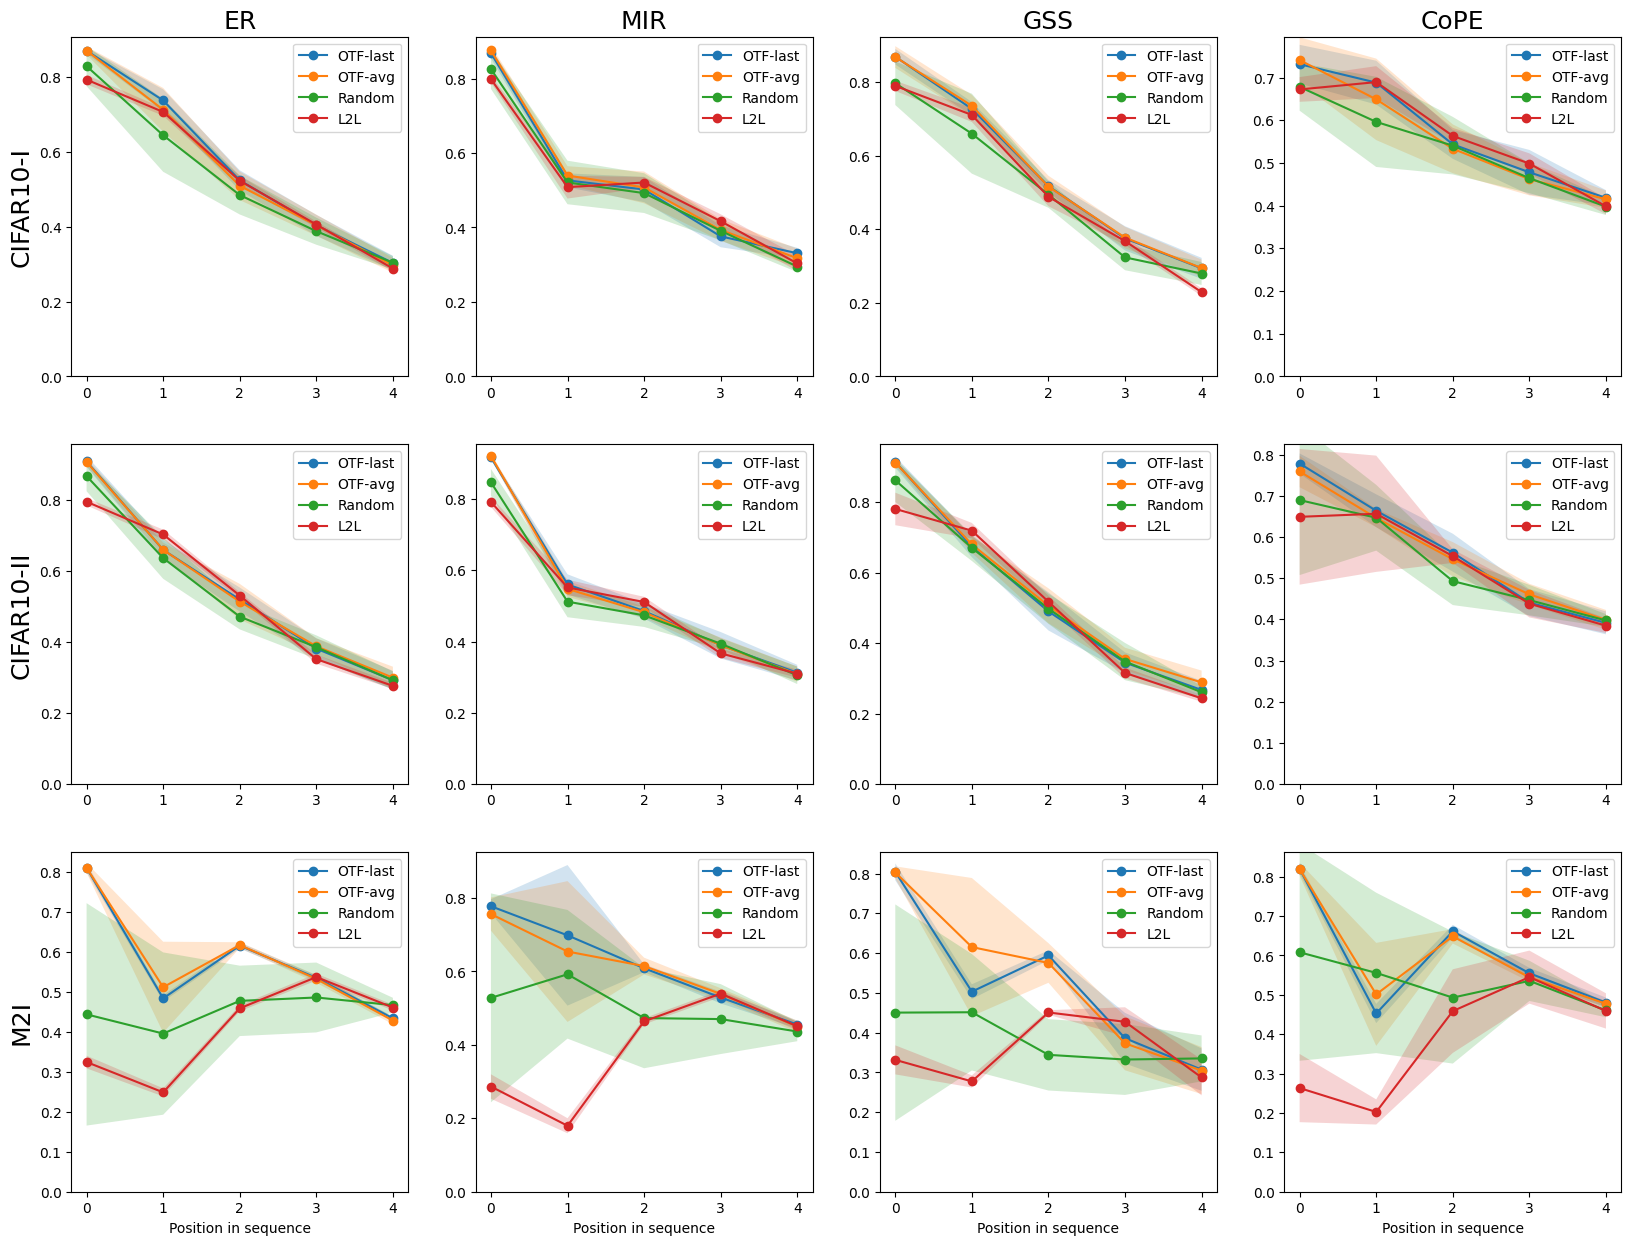

In [7]:
fig, axs = plt.subplots(len(five_task_datasets), len(strategies), figsize=(5*len(strategies), 5*len(five_task_datasets)))
for row_idx, dataset in enumerate(five_task_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=18)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=18)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence")
        for cd in five_task_cds:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)
            std  = np.std(cd_results["accuracy"], axis=0)

            axs[row_idx, col_idx].plot(mean, marker="o")
            
        for cd in five_task_cds:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)
            std  = np.std(cd_results["accuracy"], axis=0)
            axs[row_idx, col_idx].fill_between(
                x=np.arange(5), y1=mean - std, y2=mean + std, alpha=0.2
            )
            
            axs[row_idx, col_idx].set_ylim(bottom=0)
        axs[row_idx, col_idx].legend([cd_to_name[cd] for cd in five_task_cds])

plt.savefig("results/cd_evaluation/evolution_cd_performance/5-task-datasets_incremental-accuracy.png")

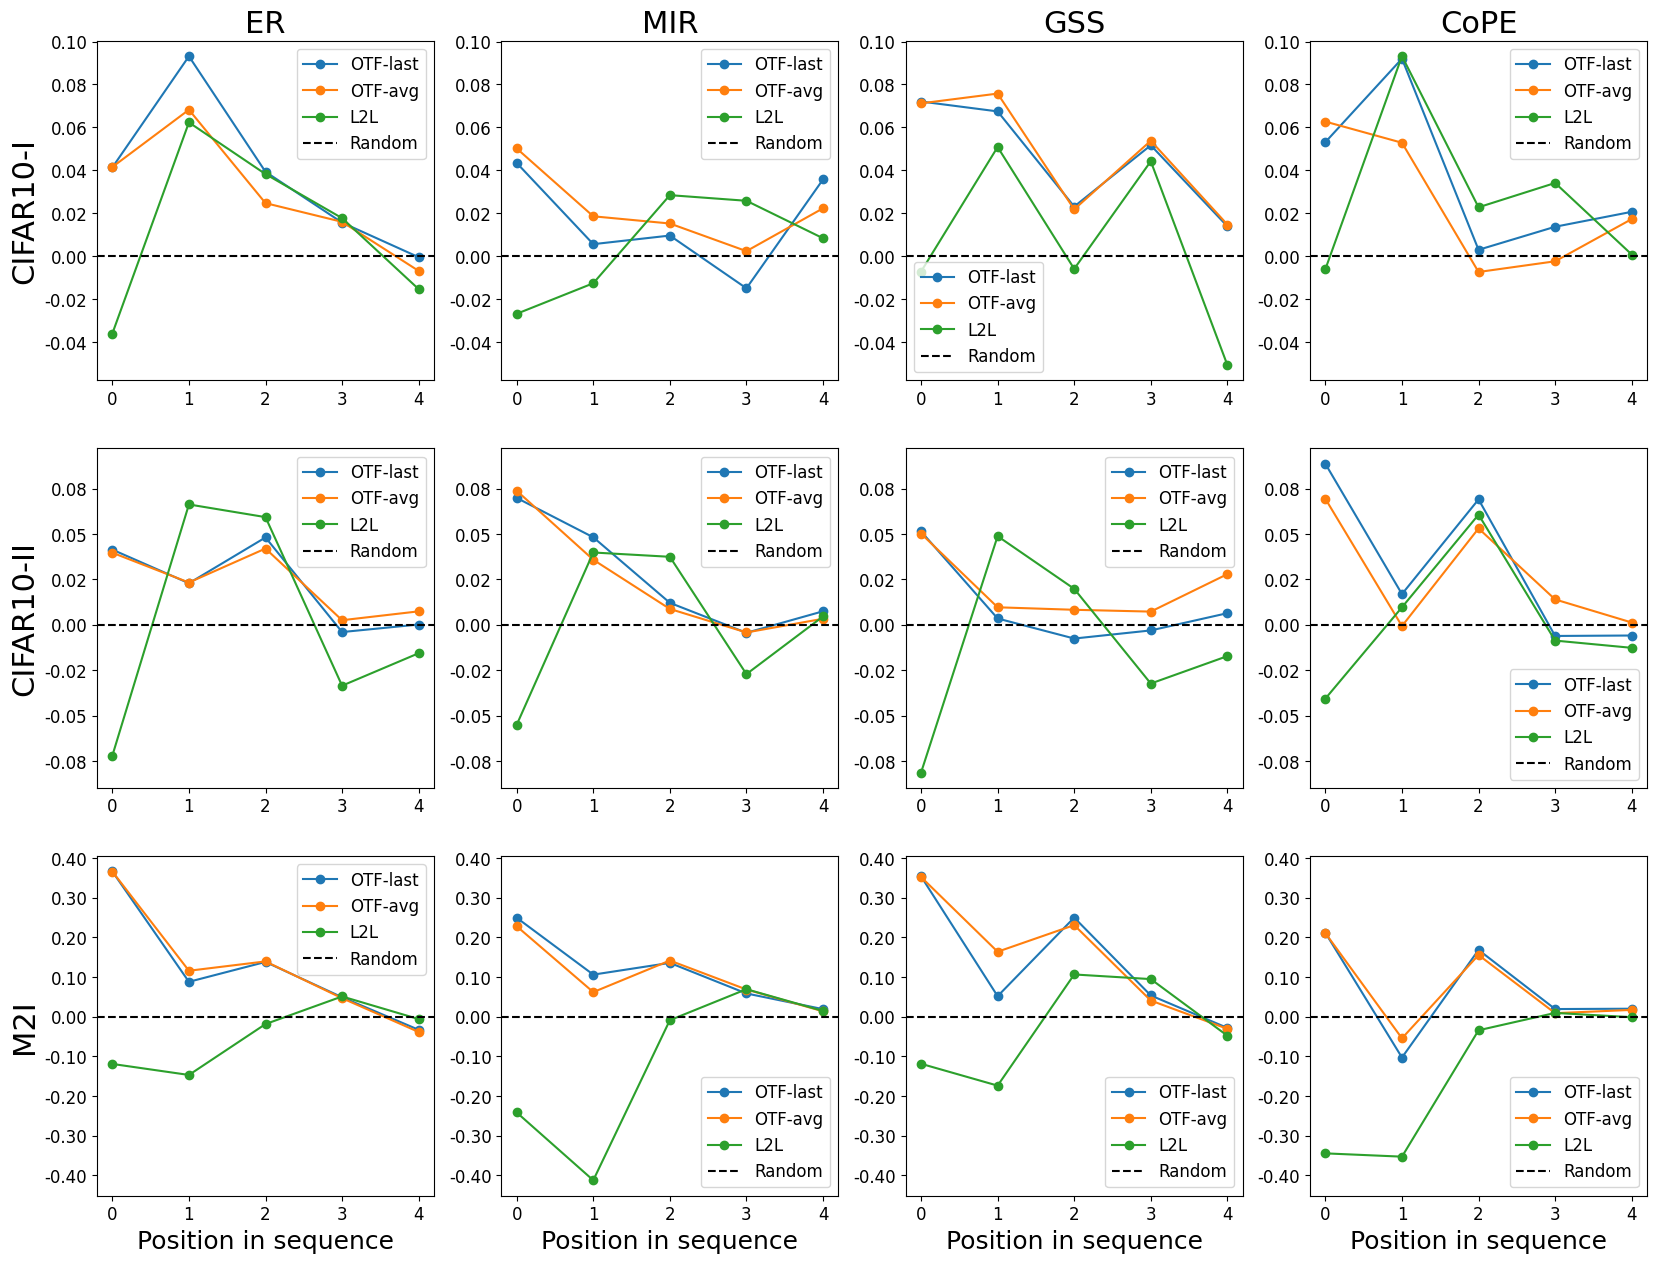

In [33]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(len(five_task_datasets), len(strategies), sharey='row', figsize=(5*len(strategies), 5*len(five_task_datasets)))
for row_idx, dataset in enumerate(five_task_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=22)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=22)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence", fontsize=18)

        random_cd_results = load_results(dataset, strategy, cd="random")
        random_mean = np.mean(random_cd_results["accuracy"], axis=0)
        
        for cd in ["on the fly-center-max-false", "on the fly-center-max-true", "L2L"]:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)

            axs[row_idx, col_idx].plot(mean - random_mean, marker="o", label=cd_to_name[cd])
            
        axs[row_idx, col_idx].axhline(y=0, color='black', linestyle='--', label='Random')
        axs[row_idx, col_idx].legend(fontsize=12)
        for axes in axs:
            for ax in axes:
                ax.tick_params(axis='both', which='major', labelsize=12)
    formatter = FormatStrFormatter('%.2f')
    for ax in axs.flat:
        ax.yaxis.set_major_formatter(formatter)
        ax.tick_params(axis='y', which='both', labelleft=True)

plt.savefig("results/cd_evaluation/evolution_cd_performance/5task-datasets_incremental-accuracy-diff-to-random.png")

#### Evolution of per task accuracy

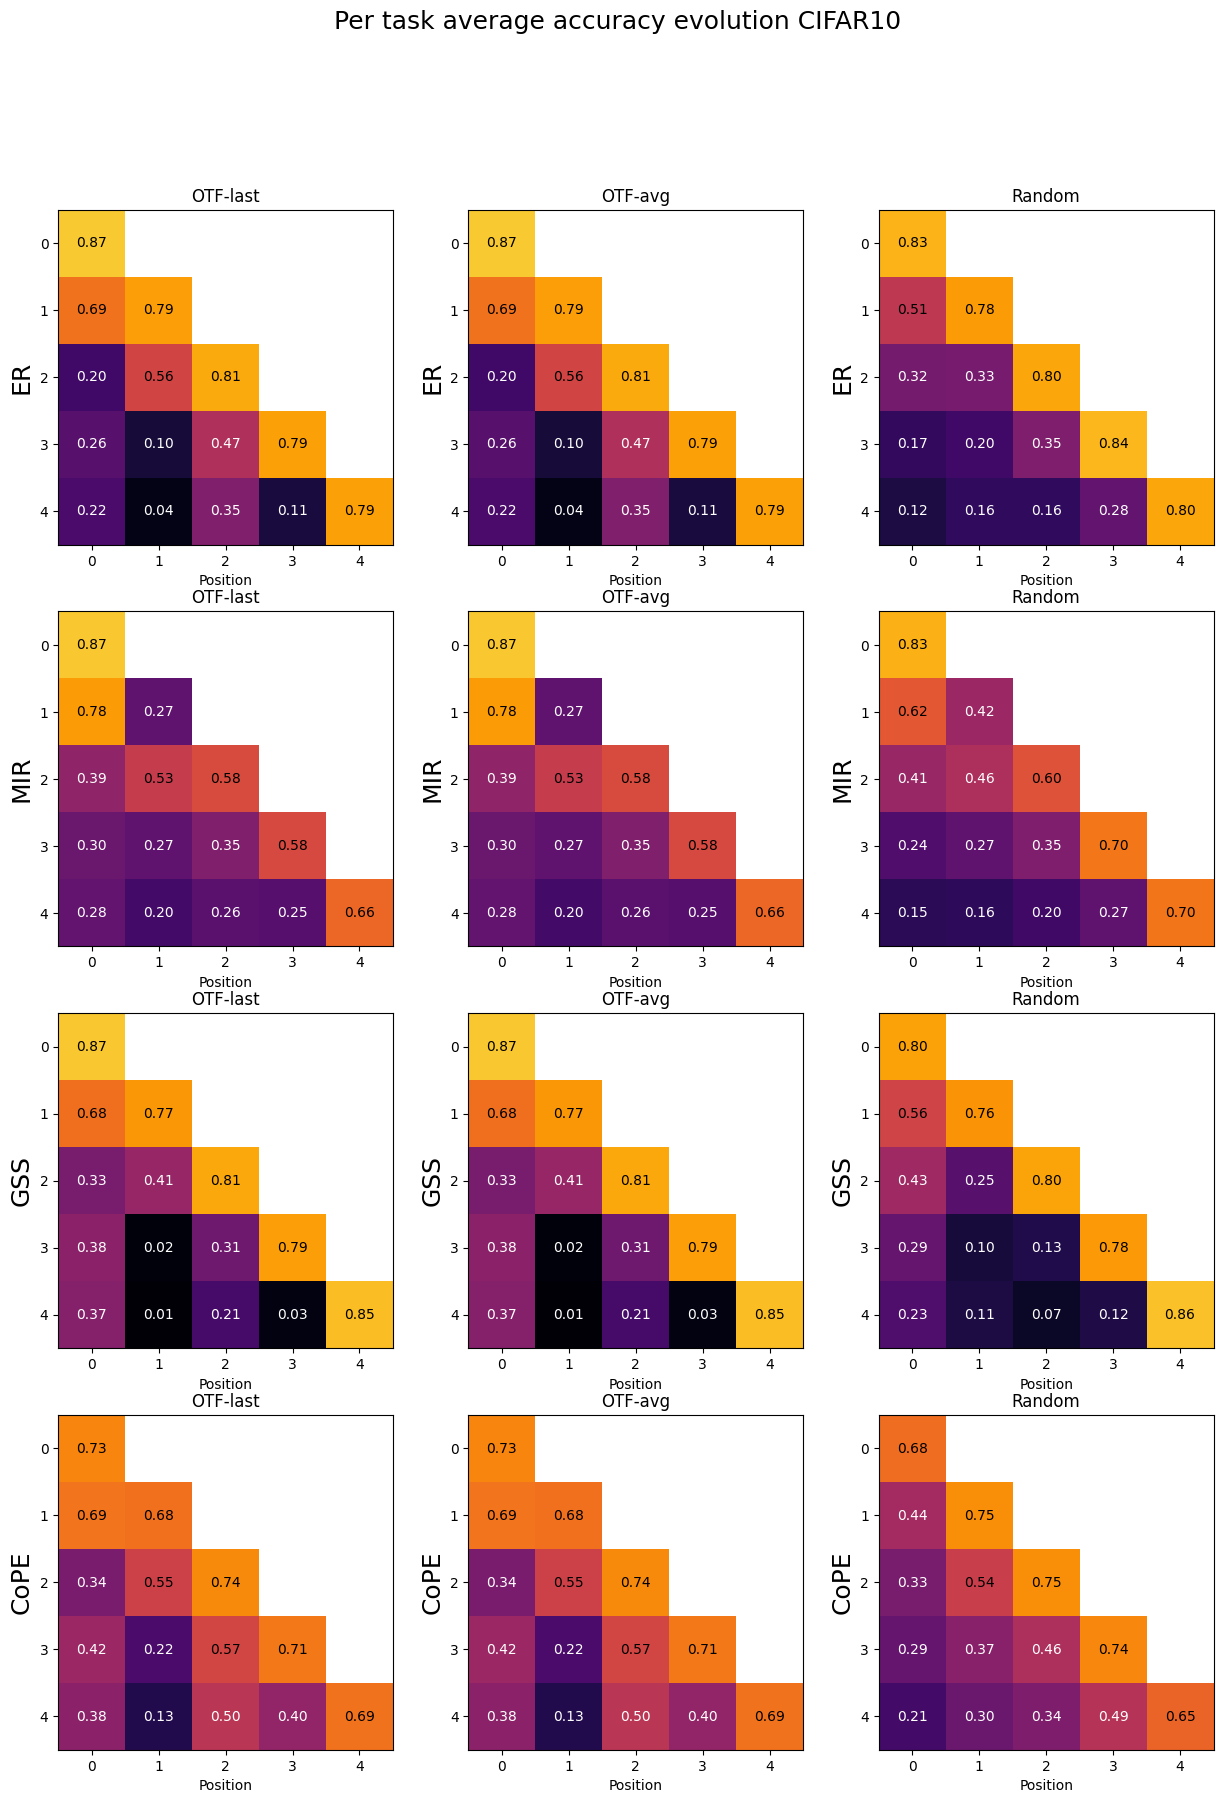

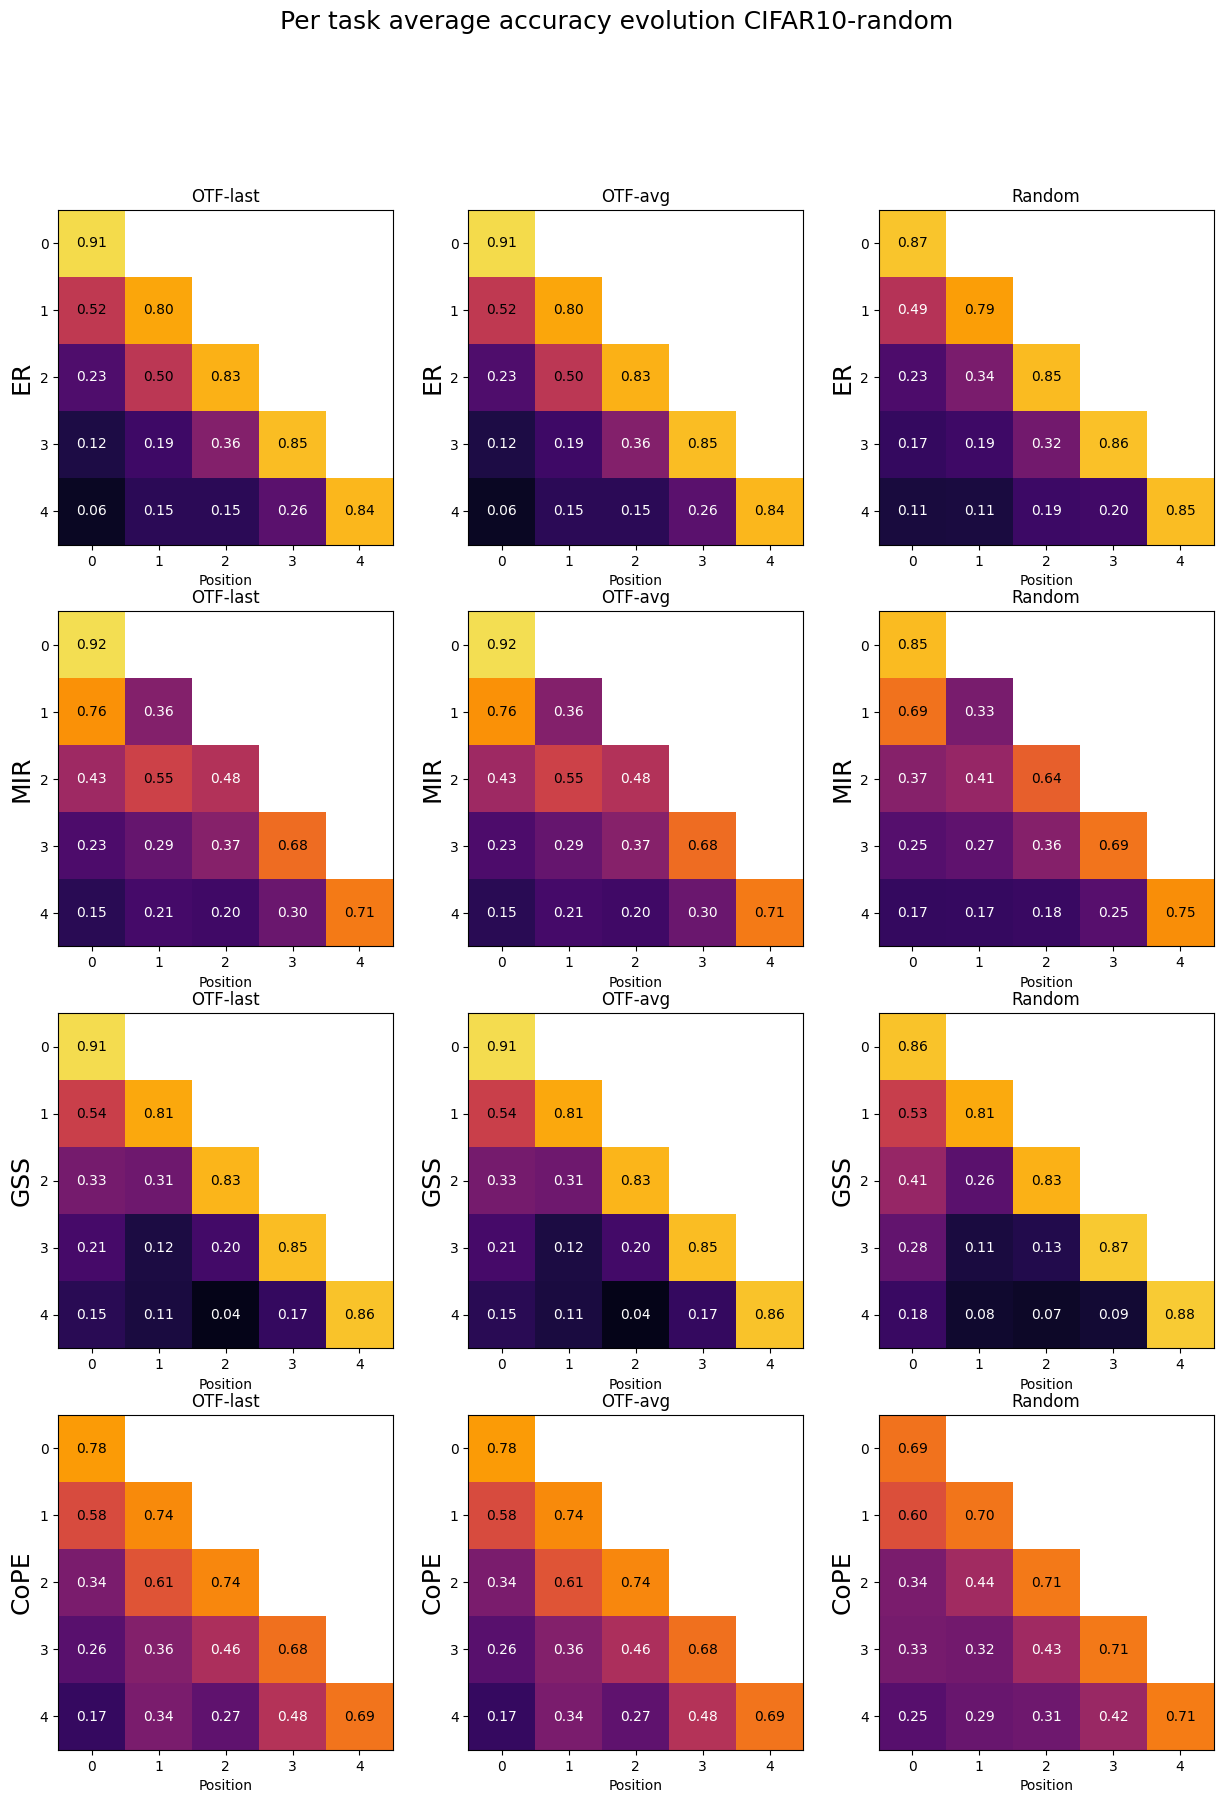

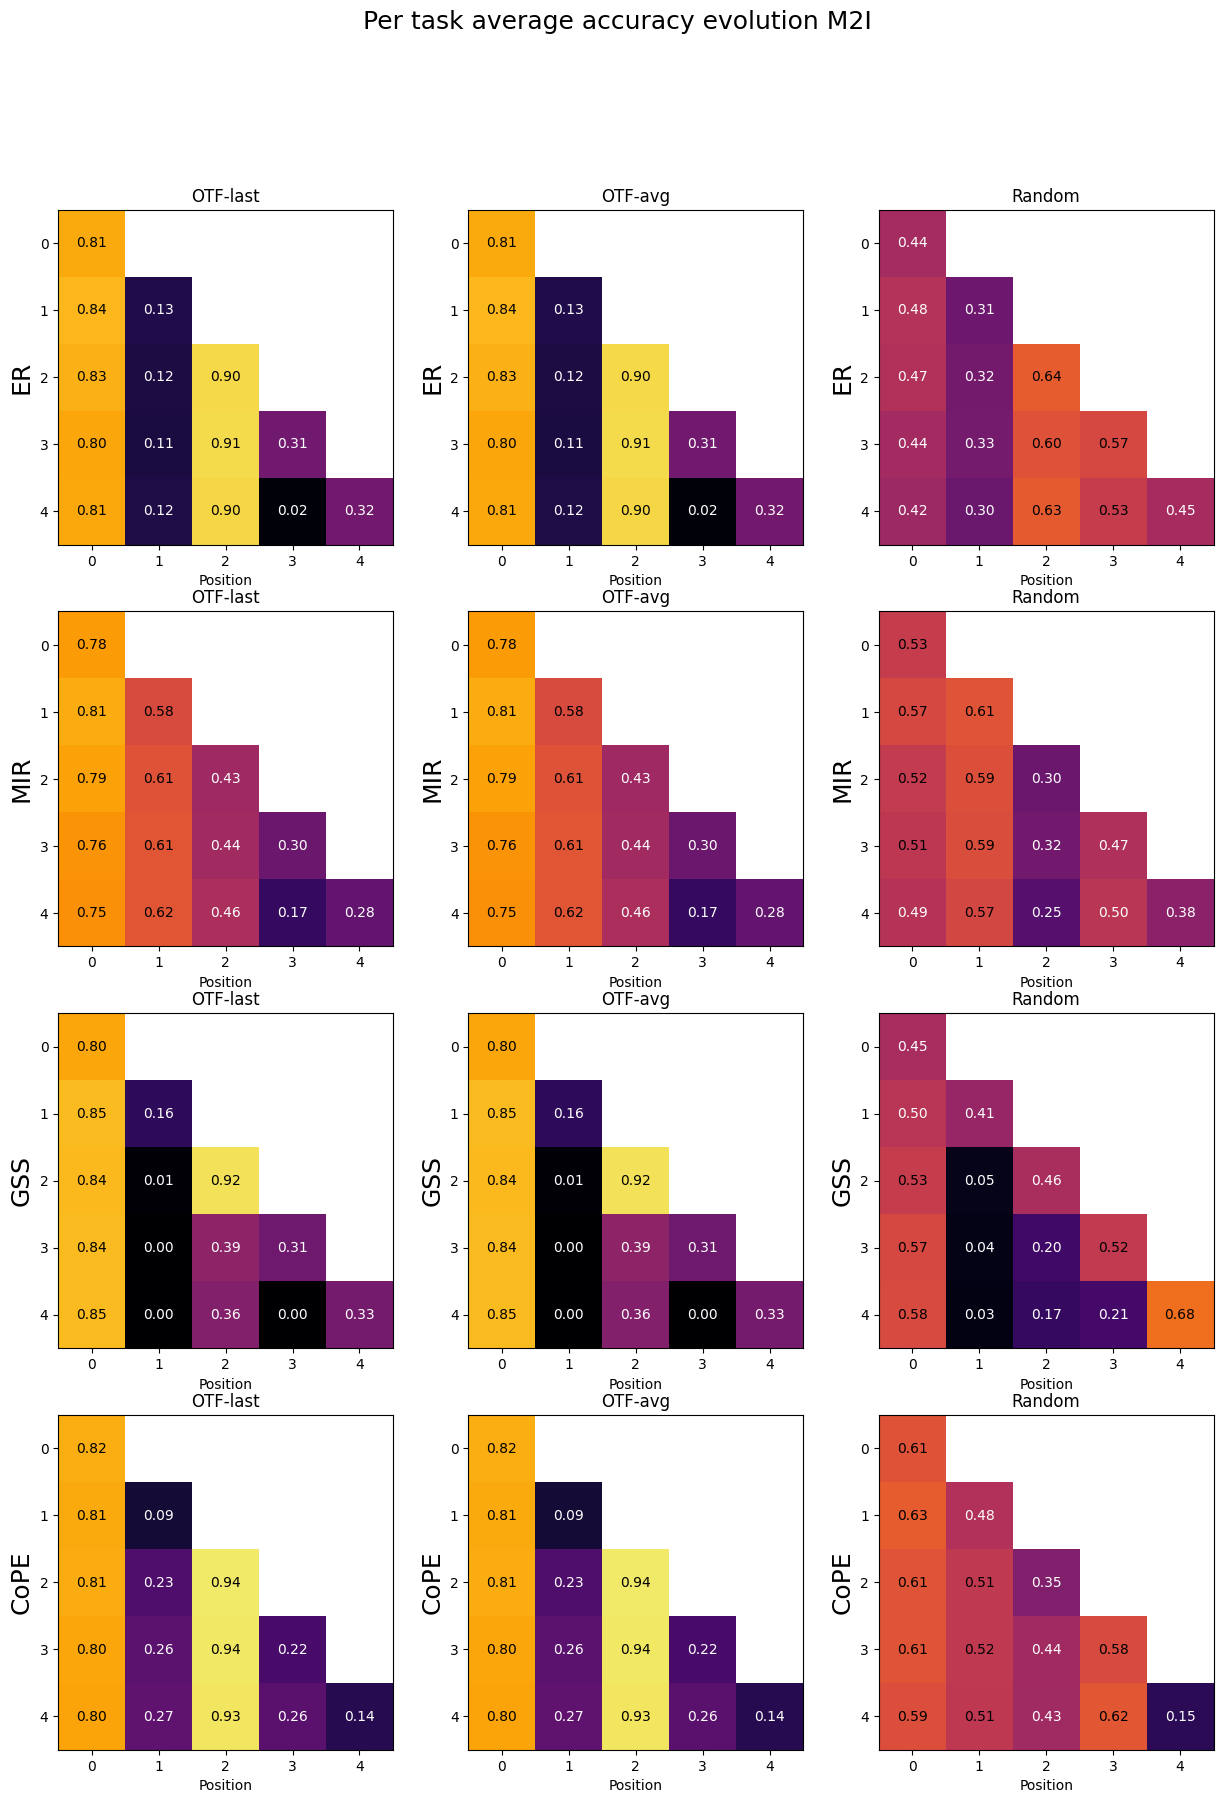

In [9]:
for dataset in five_task_datasets:
    fig, axs = plt.subplots(len(strategies), 3, figsize=(15, 20))
    fig.suptitle(f"Per task average accuracy evolution {dataset}", fontsize=18)
    for row_idx, strategy in enumerate(strategies):
        otf_last_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        otf_avg_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        random_cd_results  = load_results(dataset, strategy, "random")
        
        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        otf_last_per_position_performance = np.zeros(np.array(otf_last_cd_results["accuracy per task"]).shape)
        for run_id in range(len(otf_last_cd_results["ordering"])):
            run_ordering = otf_last_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    otf_last_per_position_performance[run_id, seq_id, position] = otf_last_cd_results["accuracy per task"][run_id][seq_id][task]

        otf_last_per_position_performance_mean = np.mean(otf_last_per_position_performance, axis=0)
        otf_last_per_position_performance_mean[otf_last_per_position_performance_mean == -1] = None
        axs[row_idx, 0].imshow(otf_last_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 0].set_title("OTF-last")
        axs[row_idx, 0].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 0].set_xlabel("Position")
        axs[row_idx, 0].set_xticks(ticks=np.arange(len(otf_last_per_position_performance_mean)))
        axs[row_idx, 0].set_yticks(ticks=np.arange(len(otf_last_per_position_performance_mean)))

        # Add text annotations for each cell
        for i in range(otf_last_per_position_performance_mean.shape[0]):
            for j in range(otf_last_per_position_performance_mean.shape[1]):
                if otf_last_per_position_performance_mean[i, j] >= 0.5:
                    color = "black"
                else:
                    color = "white"
                axs[row_idx, 0].text(j, i, f'{otf_last_per_position_performance_mean[i, j]:.2f}', ha='center', va='center', color=color)

        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        otf_avg_per_position_performance = np.zeros(np.array(otf_avg_cd_results["accuracy per task"]).shape)
        for run_id in range(len(otf_avg_cd_results["ordering"])):
            run_ordering = otf_avg_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    otf_avg_per_position_performance[run_id, seq_id, position] = otf_avg_cd_results["accuracy per task"][run_id][seq_id][task]

        otf_avg_per_position_performance_mean = np.mean(otf_avg_per_position_performance, axis=0)
        otf_avg_per_position_performance_mean[otf_avg_per_position_performance_mean == -1] = None
        axs[row_idx, 1].imshow(otf_avg_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 1].set_title("OTF-avg")
        axs[row_idx, 1].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 1].set_xlabel("Position")
        axs[row_idx, 1].set_xticks(ticks=np.arange(len(otf_avg_per_position_performance_mean)))
        axs[row_idx, 1].set_yticks(ticks=np.arange(len(otf_avg_per_position_performance_mean)))

        # Add text annotations for each cell
        for i in range(otf_avg_per_position_performance_mean.shape[0]):
            for j in range(otf_avg_per_position_performance_mean.shape[1]):
                if otf_avg_per_position_performance_mean[i, j] >= 0.5:
                    color = "black"
                else:
                    color = "white"
                axs[row_idx, 1].text(j, i, f'{otf_avg_per_position_performance_mean[i, j]:.2f}', ha='center', va='center', color=color)

        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        random_per_position_performance = np.zeros(np.array(random_cd_results["accuracy per task"]).shape)
        for run_id in range(len(random_cd_results["ordering"])):
            run_ordering = random_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    random_per_position_performance[run_id, seq_id, position] = random_cd_results["accuracy per task"][run_id][seq_id][task]

        random_per_position_performance_mean = np.mean(random_per_position_performance, axis=0)
        random_per_position_performance_mean[random_per_position_performance_mean == -1] = None
        axs[row_idx, 2].imshow(random_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 2].set_title("Random")
        axs[row_idx, 2].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 2].set_xlabel("Position")
        axs[row_idx, 2].set_xticks(ticks=np.arange(len(random_per_position_performance_mean)))
        axs[row_idx, 2].set_yticks(ticks=np.arange(len(random_per_position_performance_mean)))

        # Add text annotations for each cell
        for i in range(random_per_position_performance_mean.shape[0]):
            for j in range(random_per_position_performance_mean.shape[1]):
                if random_per_position_performance_mean[i, j] >= 0.5:
                    color = "black"
                else:
                    color = "white"
                axs[row_idx, 2].text(j, i, f'{random_per_position_performance_mean[i, j]:.2f}', ha='center', va='center', color=color)
    plt.savefig(f"results/cd_evaluation/evolution_cd_performance/{dataset}_per_task_accuracy_heatmap.png")
    plt.show()

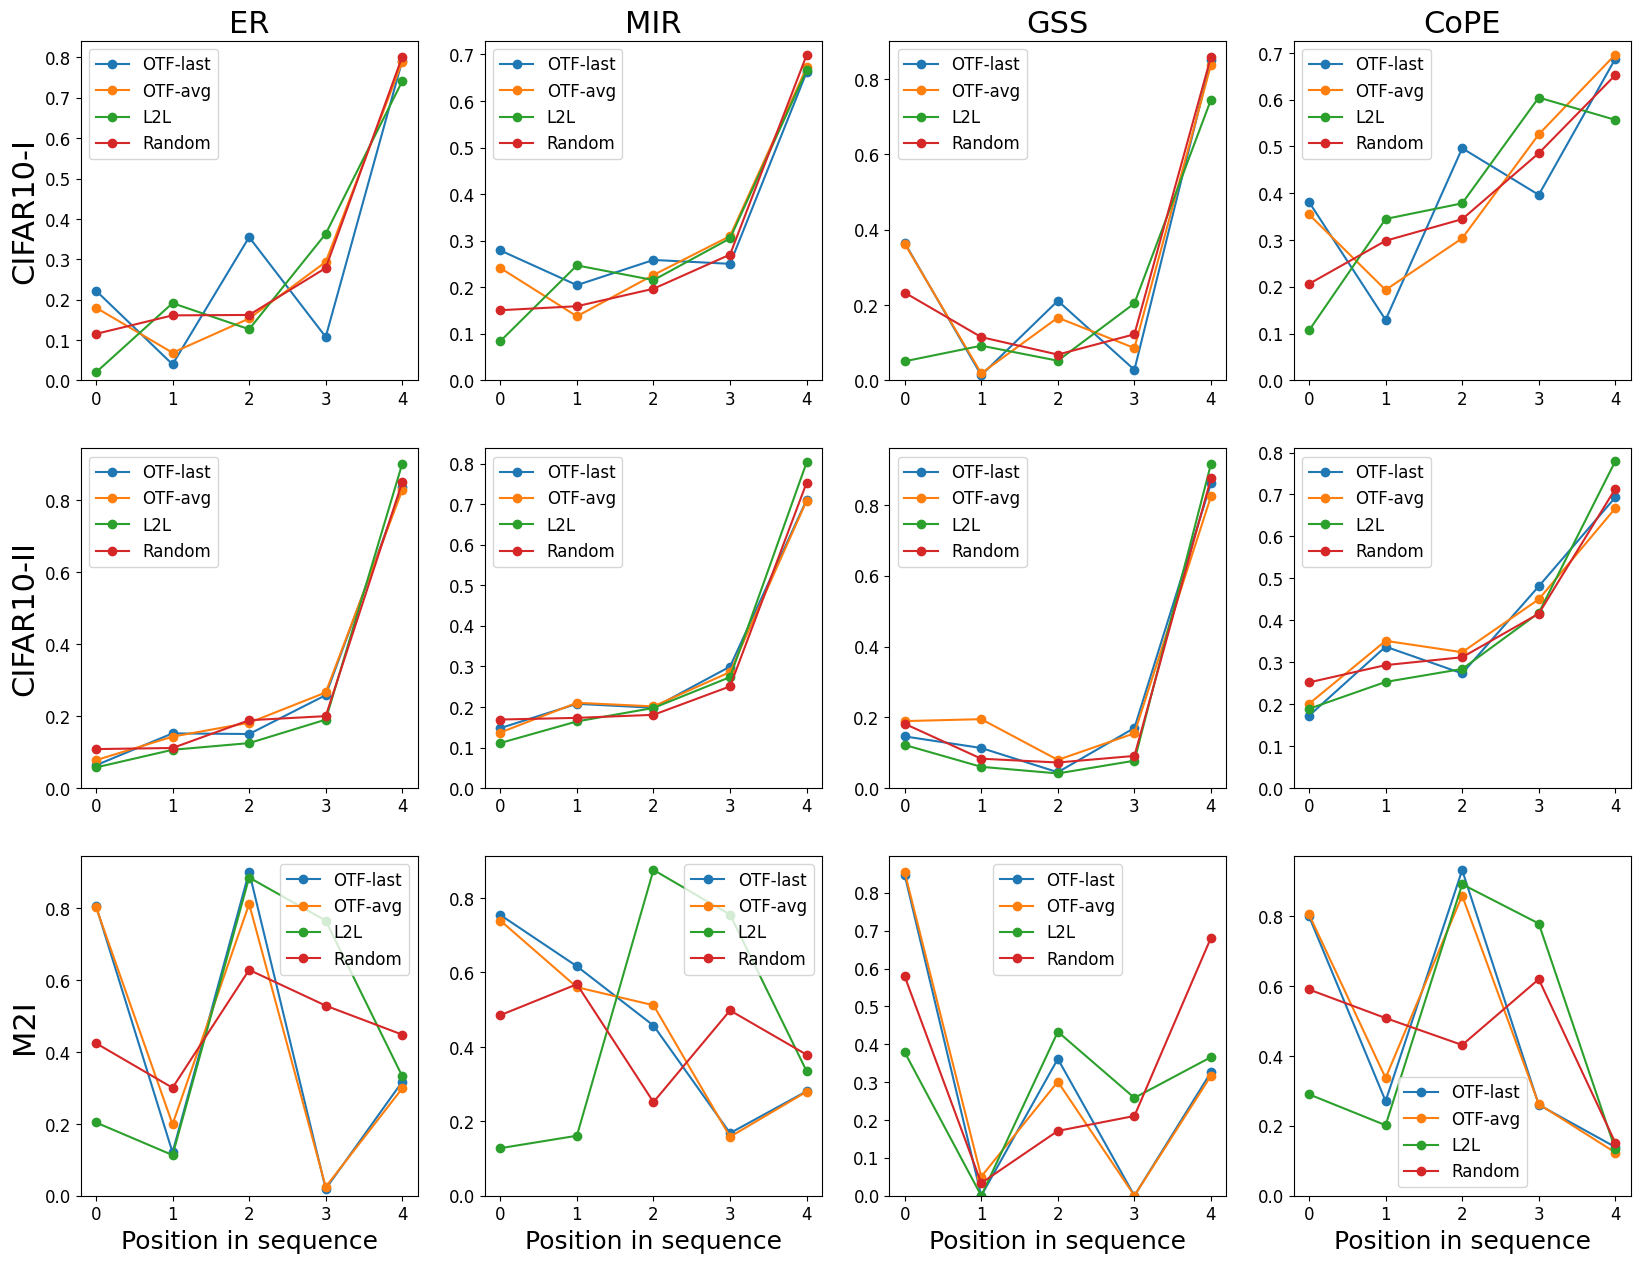

In [32]:
fig, axs = plt.subplots(len(five_task_datasets), len(strategies), figsize=(5*len(strategies), 5*len(five_task_datasets)))
for row_idx, dataset in enumerate(five_task_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=22)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=22)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence", fontsize=18)
        otf_last_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        otf_avg_cd_results = load_results(dataset, strategy, "on the fly-center-max-true")
        random_cd_results  = load_results(dataset, strategy, "random")
        l2l_results = load_results(dataset, strategy, "L2L")
        
        def compute_per_position_performance(results):
            per_position_performance = np.zeros(np.array(results["accuracy per task"]).shape)
            for run_id in range(len(results["ordering"])):
                run_ordering = results["ordering"][run_id]
                for seq_id in range(len(run_ordering)):
                    for position, task in enumerate(run_ordering):
                        per_position_performance[run_id, seq_id, position] = results["accuracy per task"][run_id][seq_id][task]
            return np.mean(per_position_performance, axis=0)

        otf_last_per_position_performance_mean = compute_per_position_performance(otf_last_cd_results)
        otf_avg_per_position_performance_mean = compute_per_position_performance(otf_avg_cd_results)
        random_per_position_performance_mean = compute_per_position_performance(random_cd_results)
        l2l_per_position_performance_mean = compute_per_position_performance(l2l_results)
        
        otf_last_per_position_performance_mean[otf_last_per_position_performance_mean == -1] = None
        otf_avg_per_position_performance_mean[otf_avg_per_position_performance_mean == -1] = None
        random_per_position_performance_mean[random_per_position_performance_mean == -1] = None
        l2l_per_position_performance_mean[l2l_per_position_performance_mean == -1] = None

        n_tasks = otf_last_per_position_performance_mean.shape[0]
        x = np.arange(n_tasks)
        width = 0.25

        # Create grouped bar chart
        axs[row_idx, col_idx].plot(otf_last_per_position_performance_mean[-1], label='OTF-last', marker='o')
        axs[row_idx, col_idx].plot(otf_avg_per_position_performance_mean[-1], label='OTF-avg', marker='o')
        axs[row_idx, col_idx].plot(l2l_per_position_performance_mean[-1], label='L2L', marker='o')
        axs[row_idx, col_idx].plot(random_per_position_performance_mean[-1], label='Random', marker='o')

        # axs[row_idx].set_xticks(x)
        # axs[row_idx].set_xticklabels(x)
        # if strategy == "gss":
        #     axs[row_idx, col_idx].legend(loc="upper center", fontsize=12)
        # else: 
        axs[row_idx, col_idx].legend(fontsize=12)
        # axs[row_idx, col_idx].grid(axis='y', linestyle='--', alpha=0.7)
        axs[row_idx, col_idx].set_ylim(bottom=0)
        for axes in axs:
            for ax in axes:
                ax.tick_params(axis='both', which='major', labelsize=12)

    

### Longer settings

#### Evolution of incremental accuracy

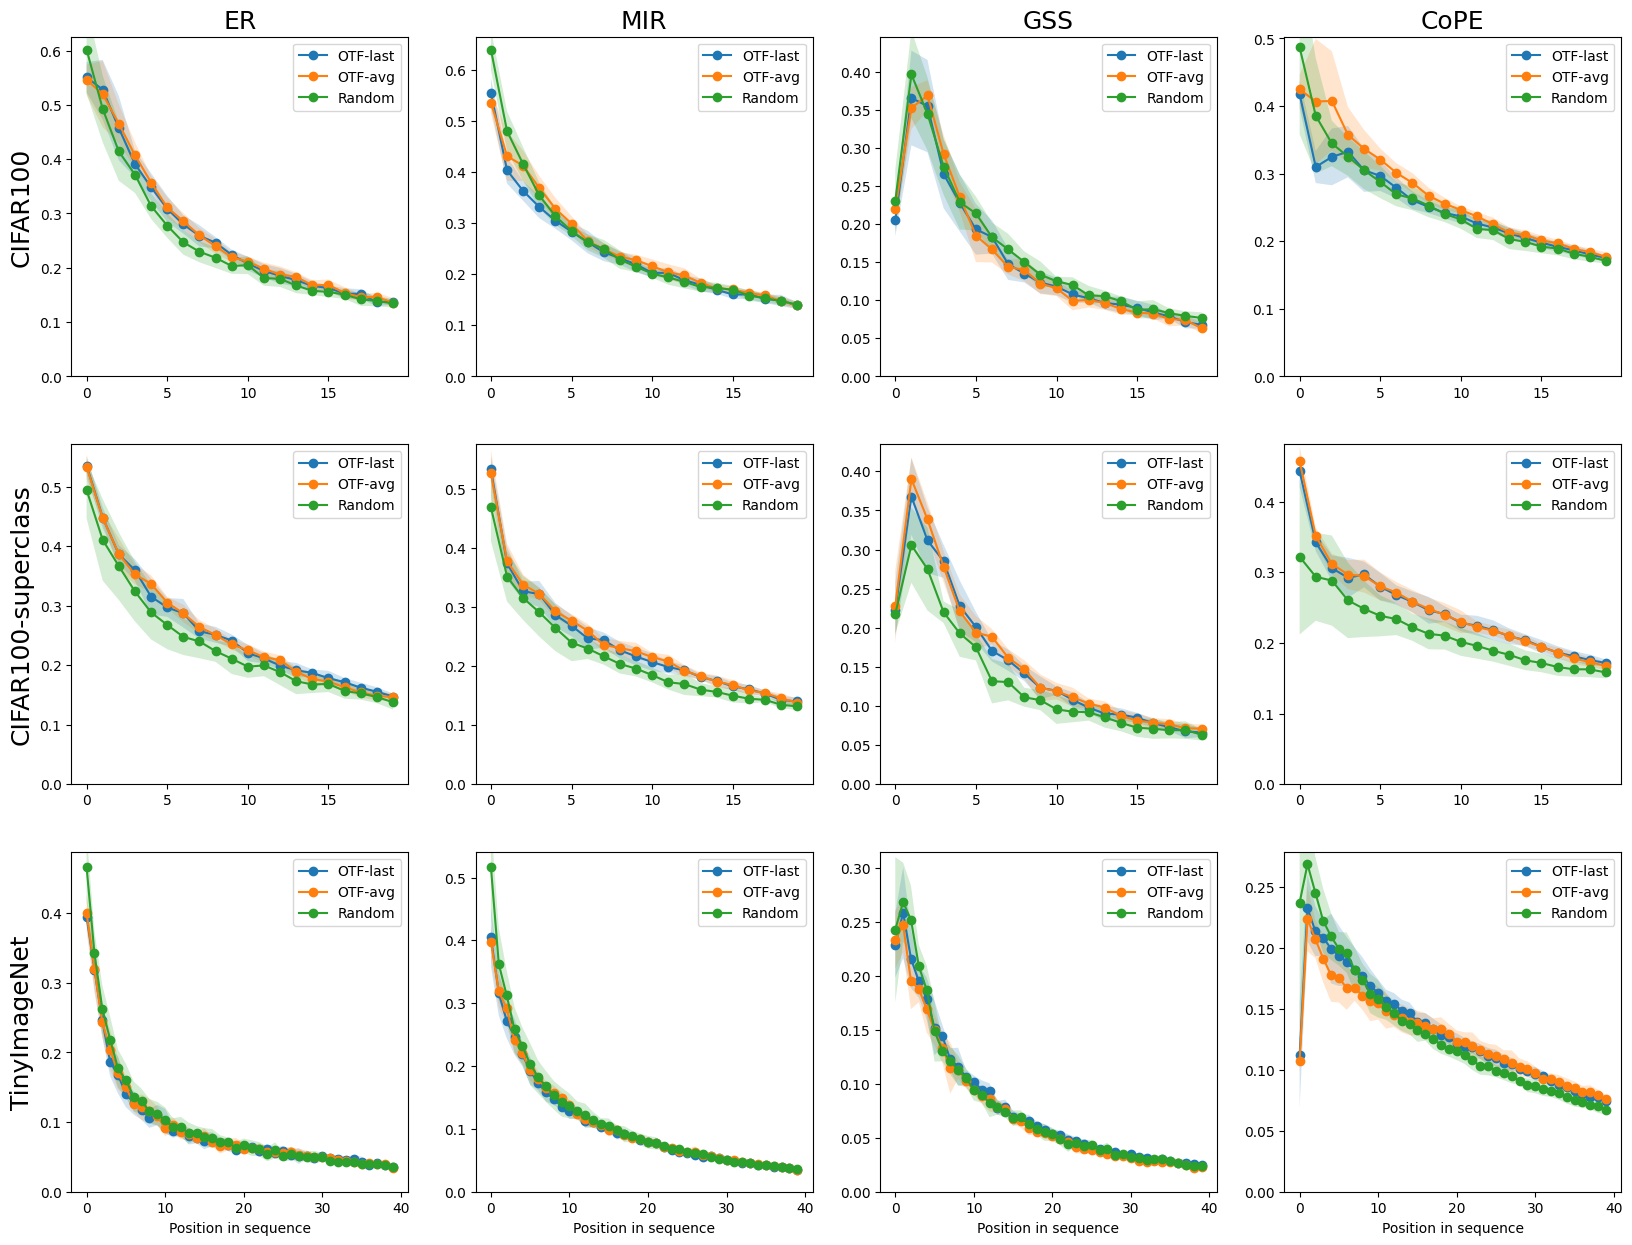

In [11]:
fig, axs = plt.subplots(len(longer_datasets), len(strategies), figsize=(5*len(strategies), 5*len(longer_datasets)))
for row_idx, dataset in enumerate(longer_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=18)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=18)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence")
        for cd in longer_cds:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)
            std  = np.std(cd_results["accuracy"], axis=0)

            axs[row_idx, col_idx].plot(mean, marker="o")
            
        for cd in longer_cds:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)
            std  = np.std(cd_results["accuracy"], axis=0)
            axs[row_idx, col_idx].fill_between(
                x=np.arange(len(mean)), y1=mean - std, y2=mean + std, alpha=0.2
            )
            
            axs[row_idx, col_idx].set_ylim(bottom=0)
        axs[row_idx, col_idx].legend([cd_to_name[cd] for cd in longer_cds])

plt.savefig("results/cd_evaluation/evolution_cd_performance/longer-datasets_incremental-accuracy.png")

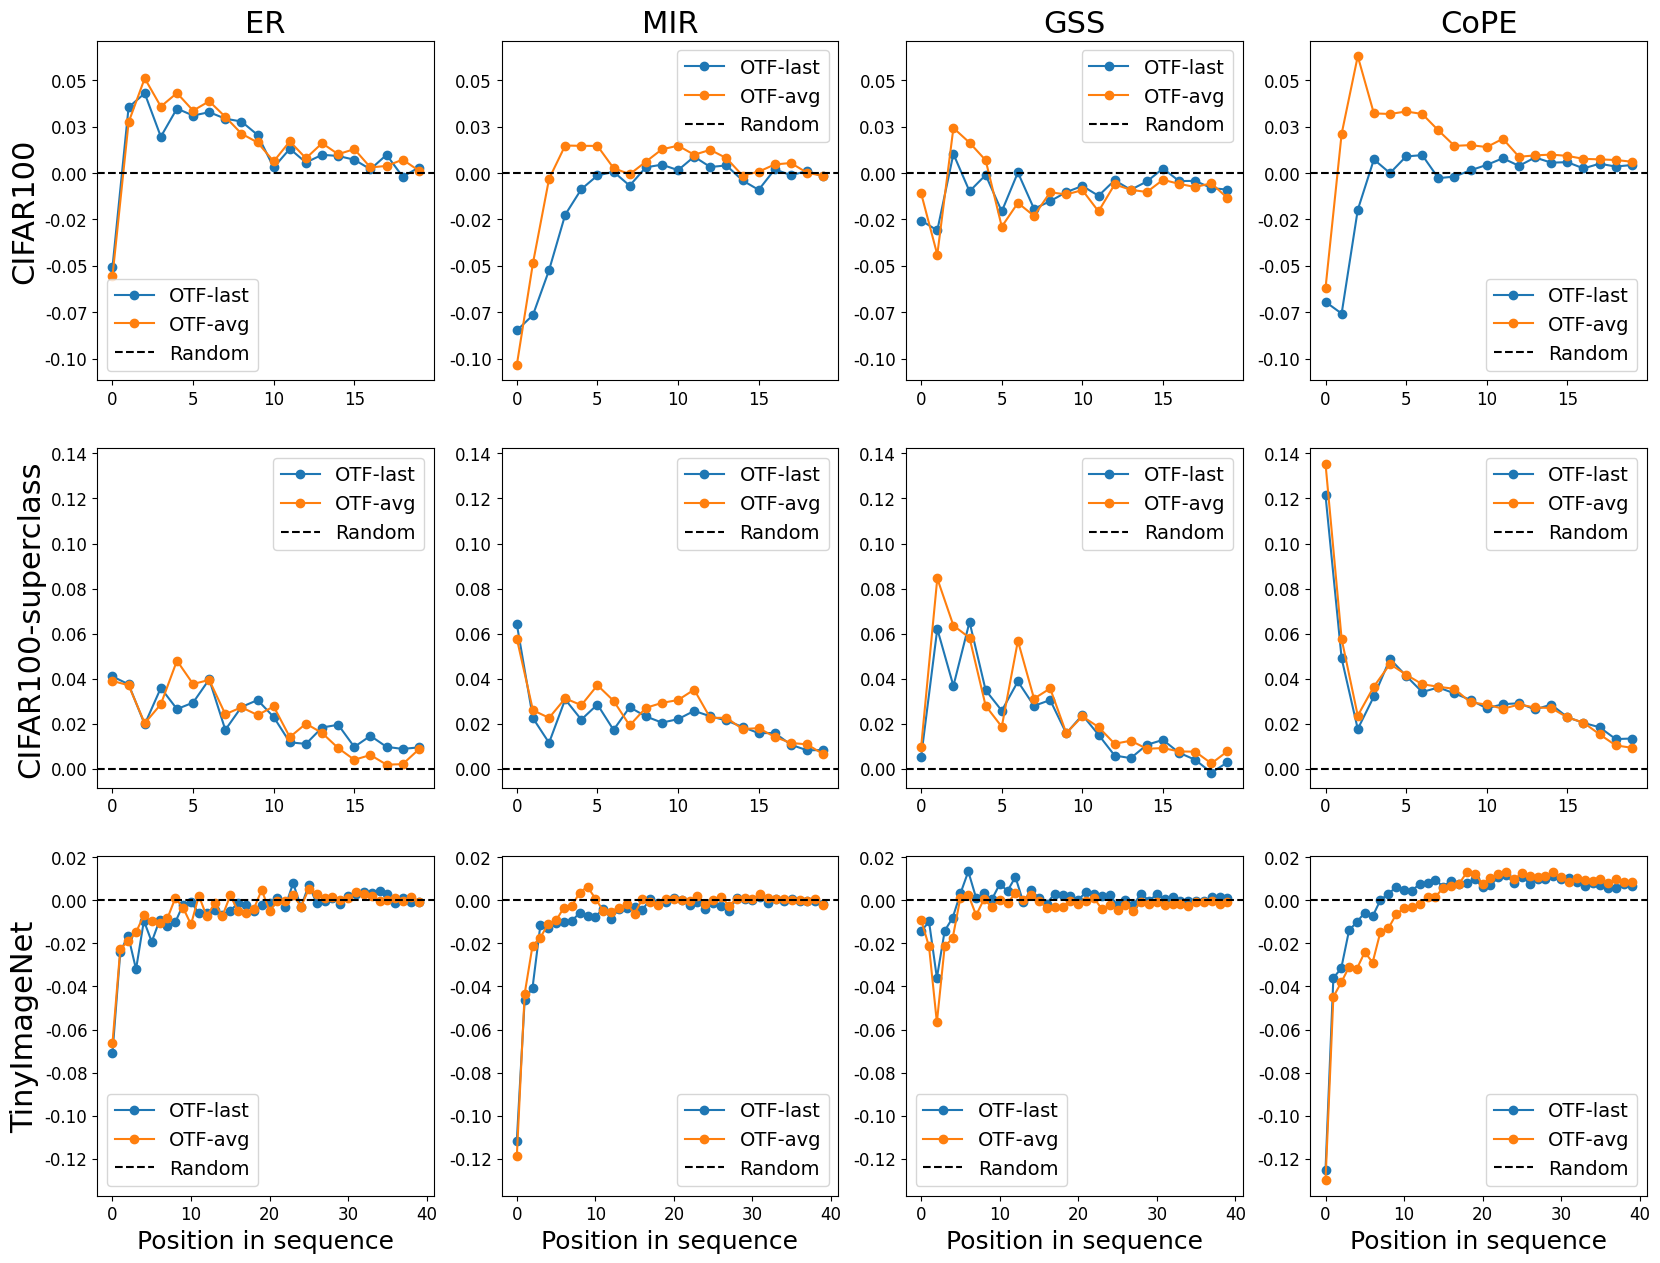

In [31]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(len(longer_datasets), len(strategies), sharey='row', figsize=(5*len(strategies), 5*len(longer_datasets)))
for row_idx, dataset in enumerate(longer_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=22)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=22)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence", fontsize=18)

        random_cd_results = load_results(dataset, strategy, cd="random")
        random_mean = np.mean(random_cd_results["accuracy"], axis=0)
        
        for cd in ["on the fly-center-max-false", "on the fly-center-max-true"]:
            cd_results = load_results(dataset, strategy, cd=cd)

            mean = np.mean(cd_results["accuracy"], axis=0)

            axs[row_idx, col_idx].plot(mean - random_mean, marker="o", label=cd_to_name[cd])
            
        axs[row_idx, col_idx].axhline(y=0, color='black', linestyle='--', label='Random')
        axs[row_idx, col_idx].legend(fontsize=14)
        for axes in axs:
            for ax in axes:
                ax.tick_params(axis='both', which='major', labelsize=12)
    formatter = FormatStrFormatter('%.2f')
    for ax in axs.flat:
        ax.yaxis.set_major_formatter(formatter)
        ax.tick_params(axis='y', which='both', labelleft=True)

plt.savefig("results/cd_evaluation/evolution_cd_performance/longer-datasets_incremental-accuracy-diff-to-random.png")

#### Evolution of per task accuracy

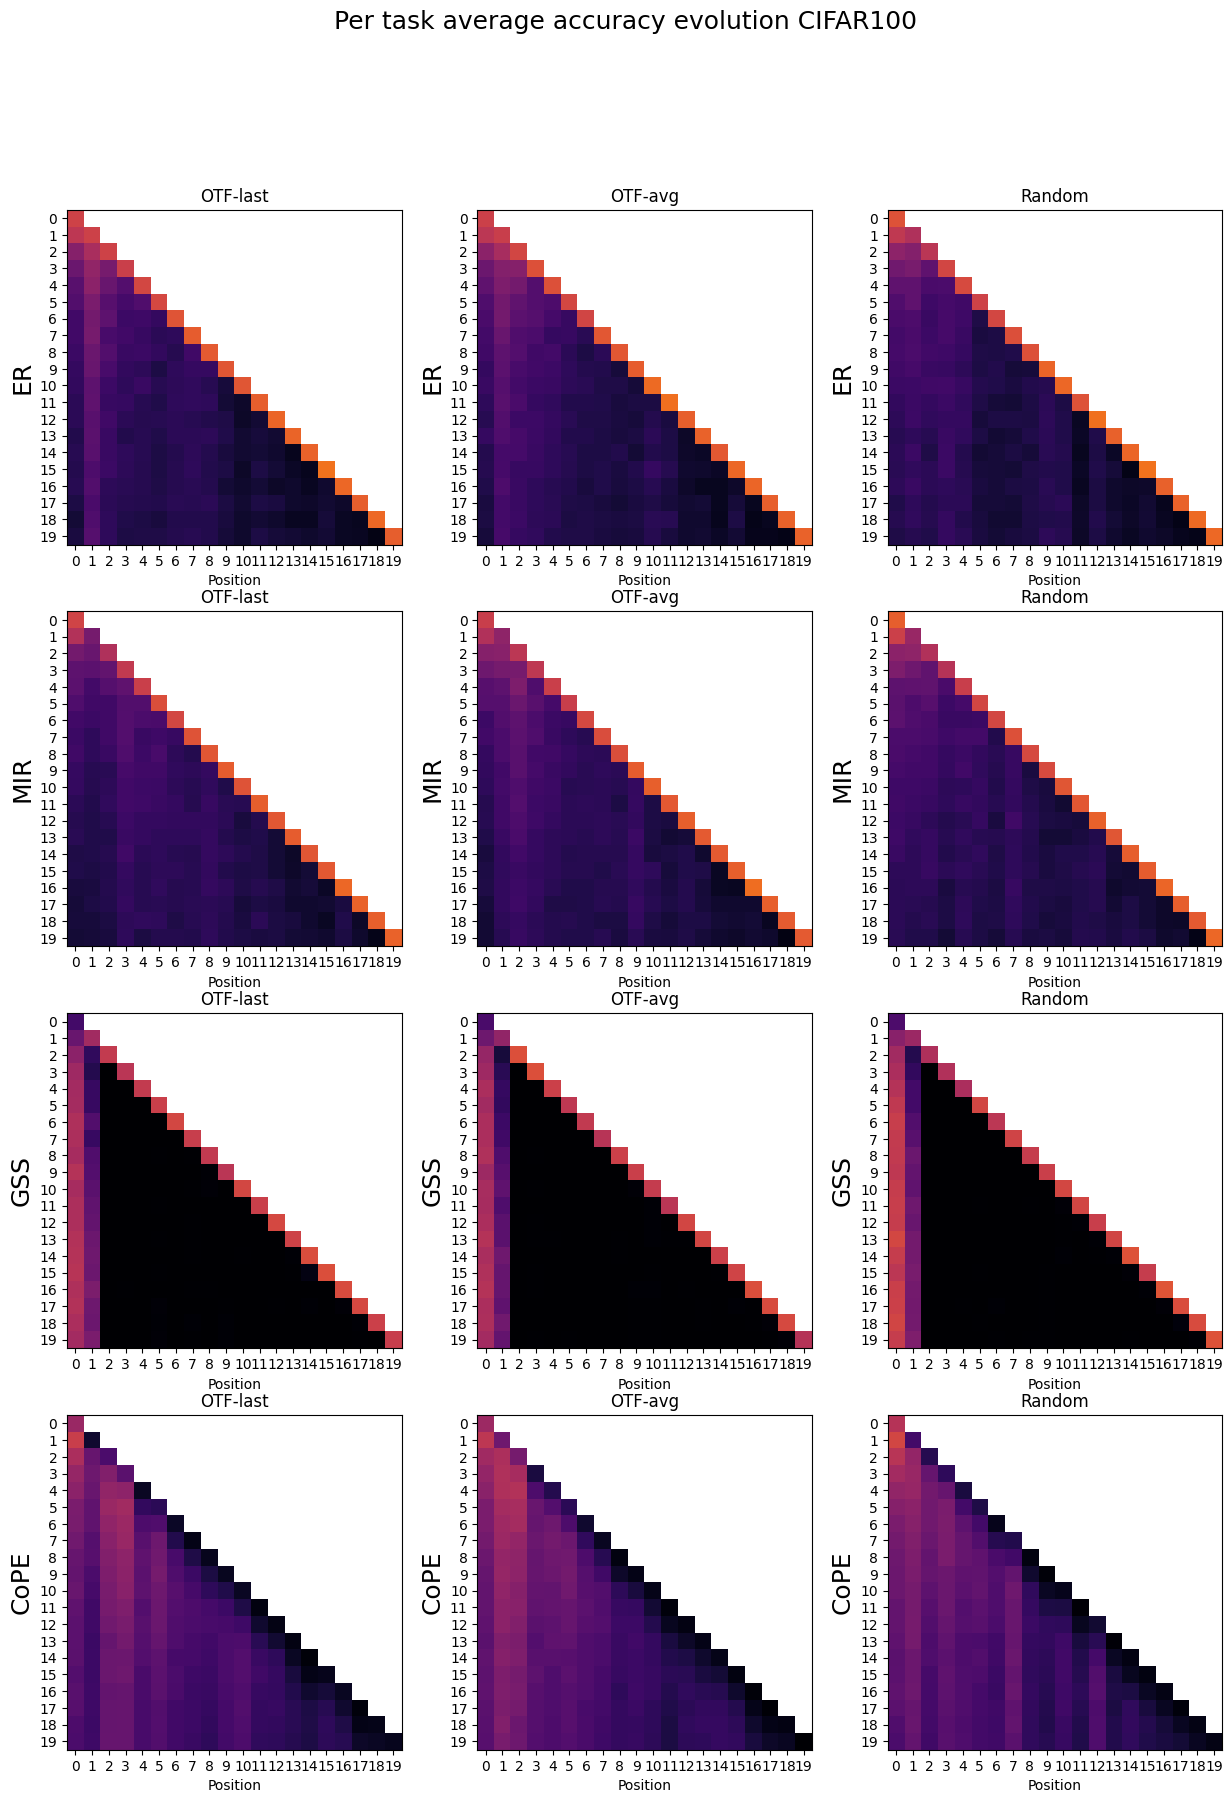

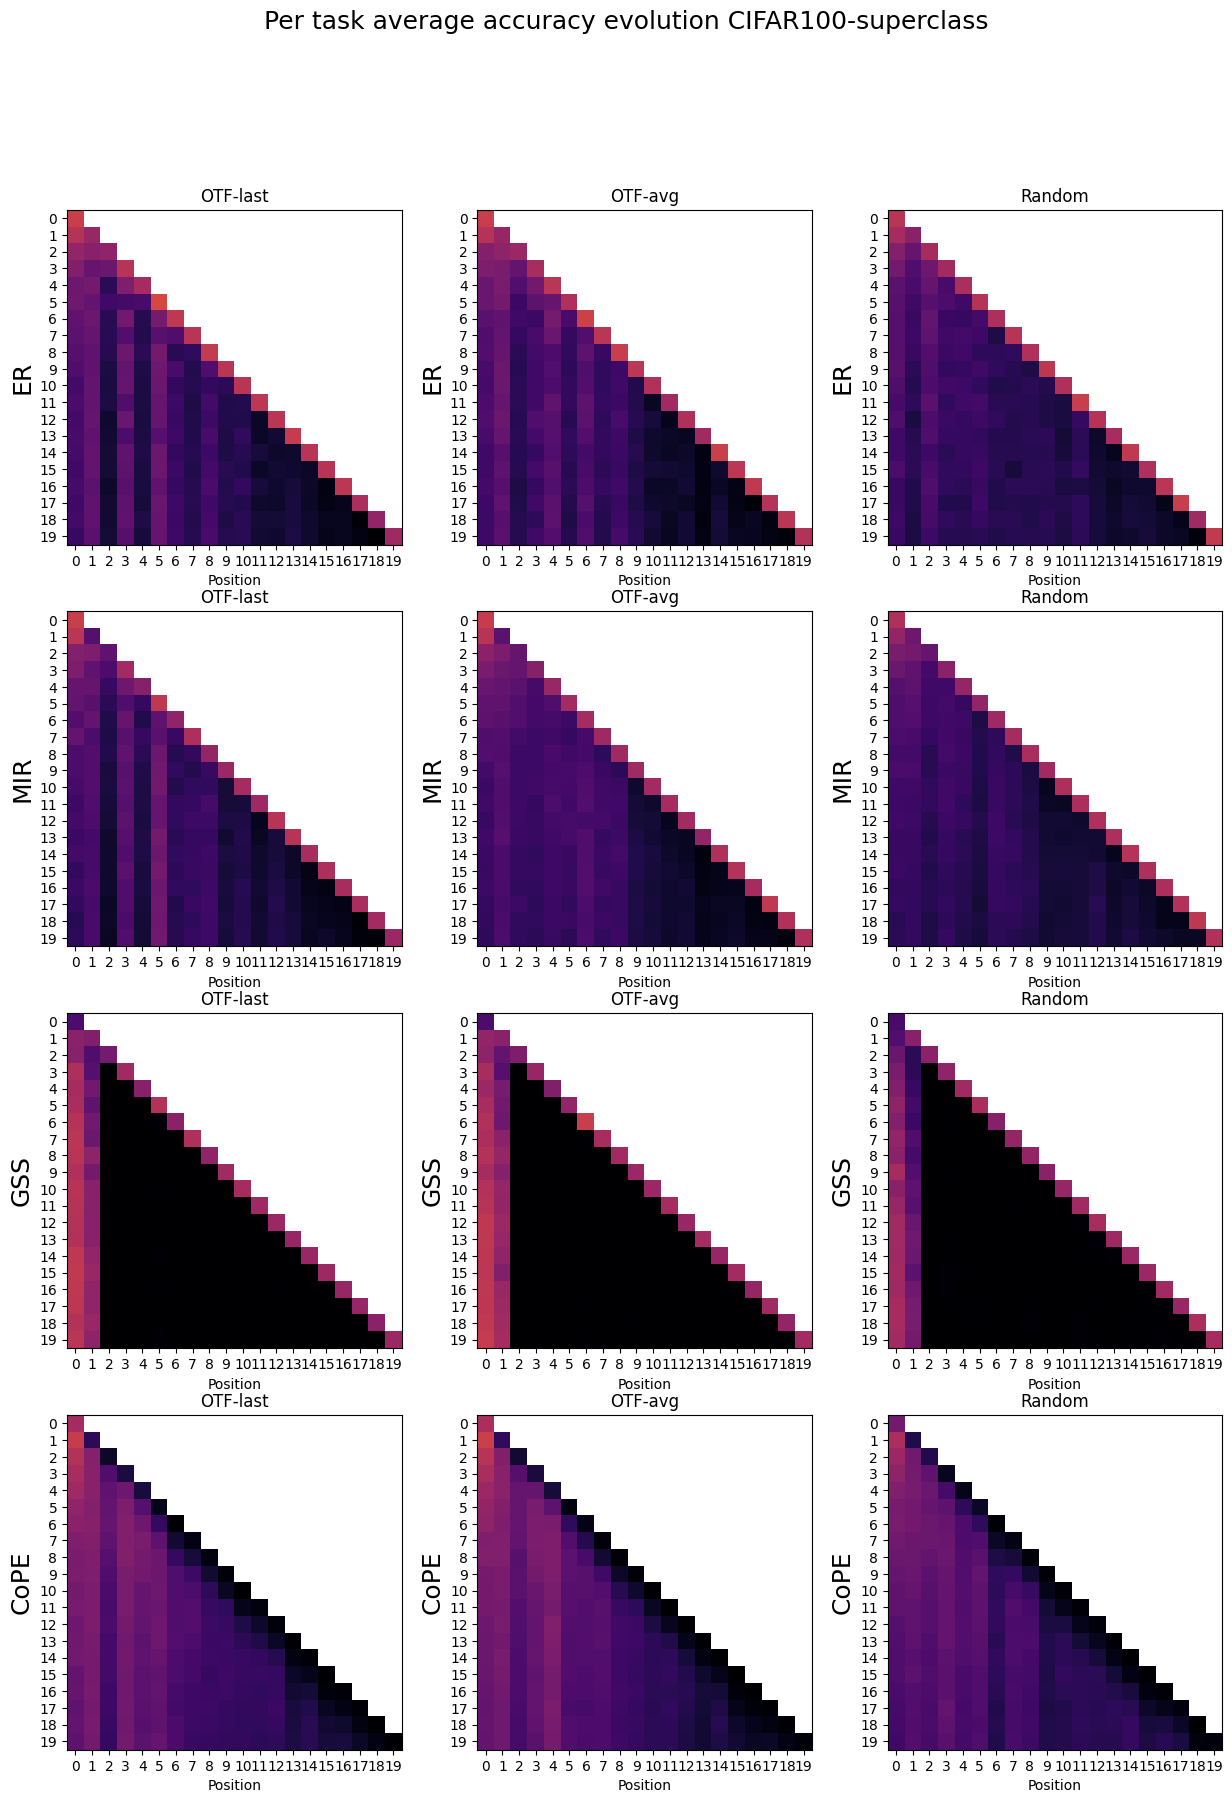

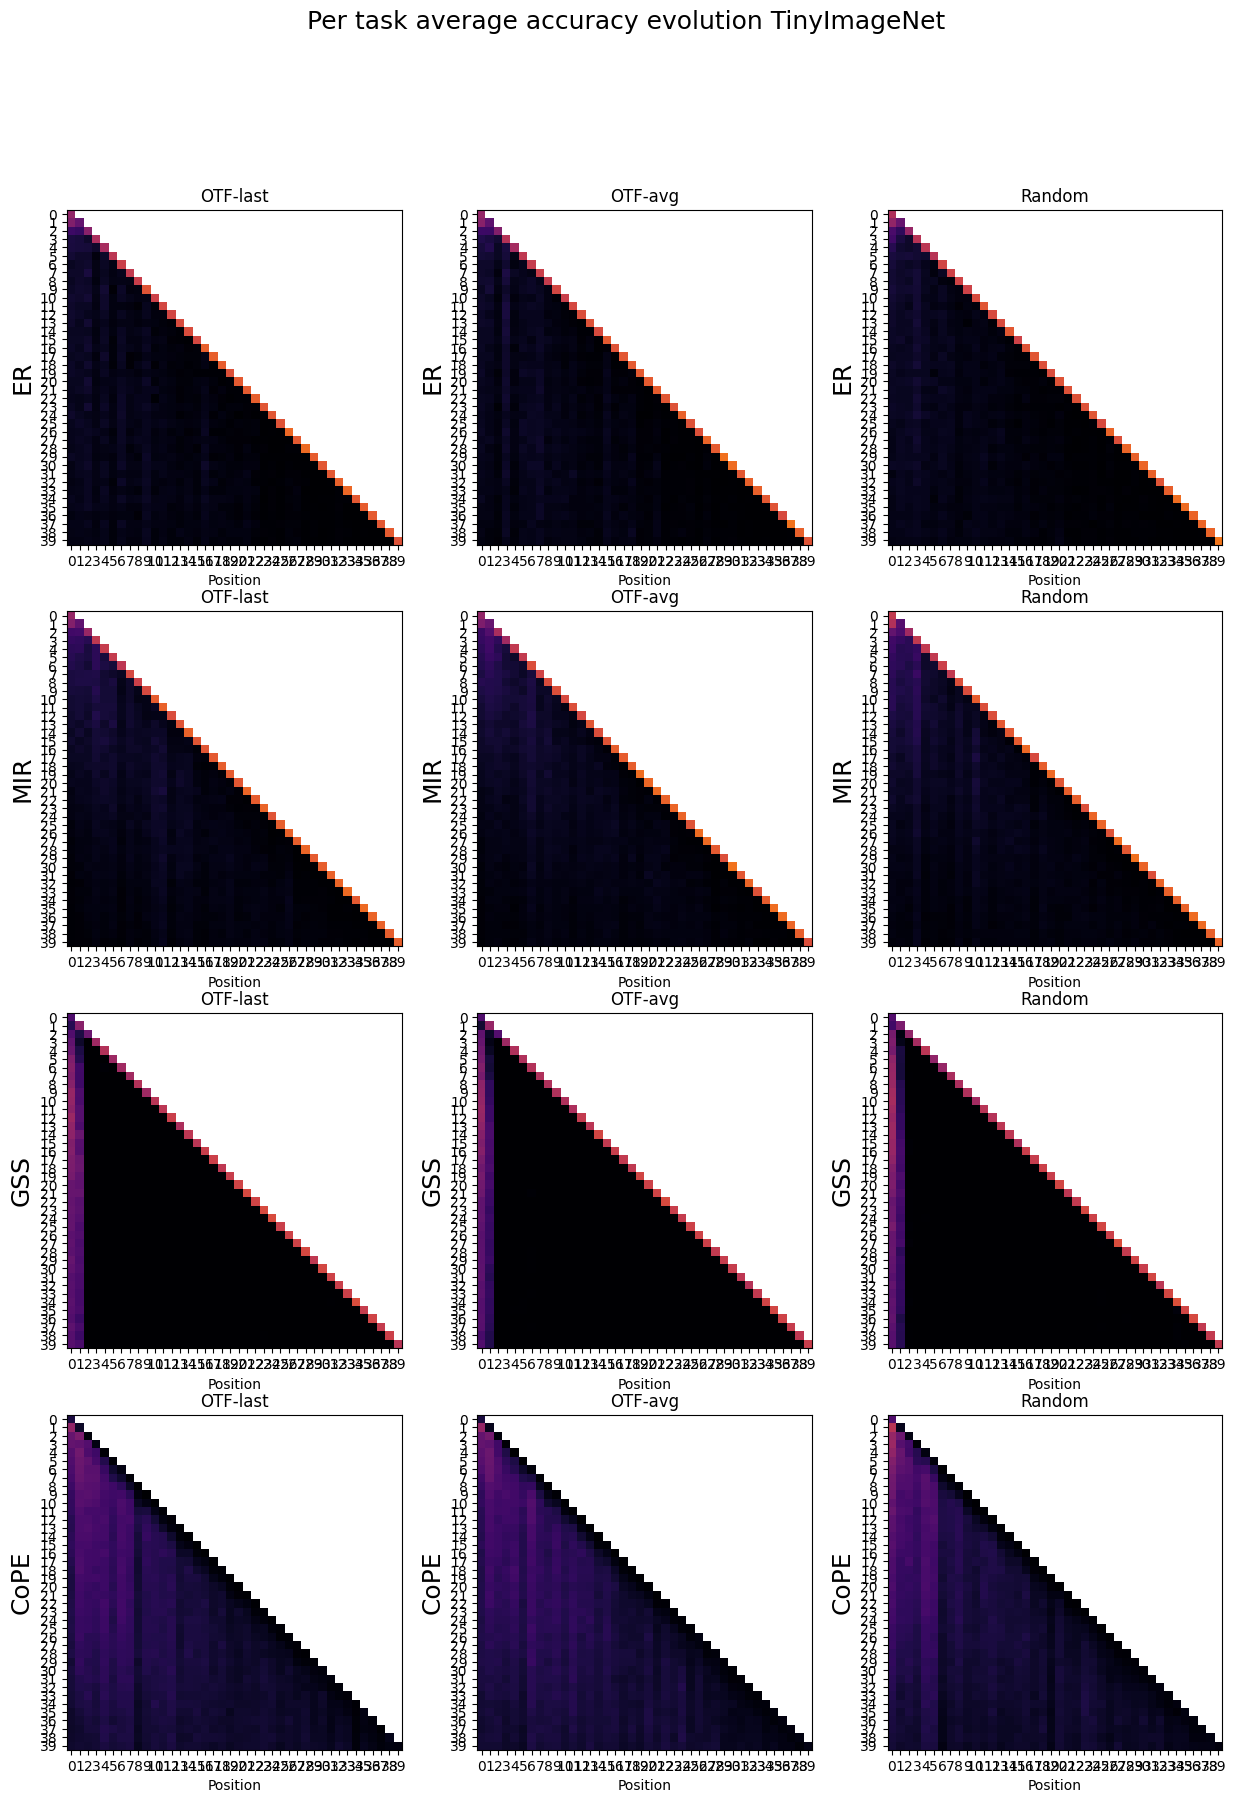

In [13]:
for dataset in longer_datasets:
    fig, axs = plt.subplots(len(strategies), 3, figsize=(15, 20))
    fig.suptitle(f"Per task average accuracy evolution {dataset}", fontsize=18)
    for row_idx, strategy in enumerate(strategies):
        otf_last_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        otf_avg_cd_results = load_results(dataset, strategy, "on the fly-center-max-true")
        random_cd_results  = load_results(dataset, strategy, "random")
        
        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        otf_last_per_position_performance = np.zeros(np.array(otf_last_cd_results["accuracy per task"]).shape)
        for run_id in range(len(otf_last_cd_results["ordering"])):
            run_ordering = otf_last_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    otf_last_per_position_performance[run_id, seq_id, position] = otf_last_cd_results["accuracy per task"][run_id][seq_id][task]

        otf_last_per_position_performance_mean = np.mean(otf_last_per_position_performance, axis=0)
        otf_last_per_position_performance_mean[otf_last_per_position_performance_mean == -1] = None
        axs[row_idx, 0].imshow(otf_last_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 0].set_title("OTF-last")
        axs[row_idx, 0].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 0].set_xlabel("Position")
        axs[row_idx, 0].set_xticks(ticks=np.arange(len(otf_last_per_position_performance_mean)))
        axs[row_idx, 0].set_yticks(ticks=np.arange(len(otf_last_per_position_performance_mean)))

        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        otf_avg_per_position_performance = np.zeros(np.array(otf_avg_cd_results["accuracy per task"]).shape)
        for run_id in range(len(otf_avg_cd_results["ordering"])):
            run_ordering = otf_avg_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    otf_avg_per_position_performance[run_id, seq_id, position] = otf_avg_cd_results["accuracy per task"][run_id][seq_id][task]

        otf_avg_per_position_performance_mean = np.mean(otf_avg_per_position_performance, axis=0)
        otf_avg_per_position_performance_mean[otf_avg_per_position_performance_mean == -1] = None
        axs[row_idx, 1].imshow(otf_avg_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 1].set_title("OTF-avg")
        axs[row_idx, 1].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 1].set_xlabel("Position")
        axs[row_idx, 1].set_xticks(ticks=np.arange(len(otf_avg_per_position_performance_mean)))
        axs[row_idx, 1].set_yticks(ticks=np.arange(len(otf_avg_per_position_performance_mean)))

        # Get a numpy array of shape n_tasks * n_tasks, where each row corresponds to a step in the sequence
        # and each column corresponds to the performance evolution of a task
        random_per_position_performance = np.zeros(np.array(random_cd_results["accuracy per task"]).shape)
        for run_id in range(len(random_cd_results["ordering"])):
            run_ordering = random_cd_results["ordering"][run_id]
            for seq_id in range(len(run_ordering)):
                for position, task in enumerate(run_ordering):
                    random_per_position_performance[run_id, seq_id, position] = random_cd_results["accuracy per task"][run_id][seq_id][task]

        random_per_position_performance_mean = np.mean(random_per_position_performance, axis=0)
        random_per_position_performance_mean[random_per_position_performance_mean == -1] = None
        axs[row_idx, 2].imshow(random_per_position_performance_mean, cmap='inferno', vmin=0, vmax=1)
        axs[row_idx, 2].set_title("Random")
        axs[row_idx, 2].set_ylabel(f"{strategy_to_name[strategy]}", fontsize=18)
        axs[row_idx, 2].set_xlabel("Position")
        axs[row_idx, 2].set_xticks(ticks=np.arange(len(random_per_position_performance_mean)))
        axs[row_idx, 2].set_yticks(ticks=np.arange(len(random_per_position_performance_mean)))
    plt.savefig(f"results/cd_evaluation/evolution_cd_performance/{dataset}_per_task_accuracy_heatmap.png")
    plt.show()

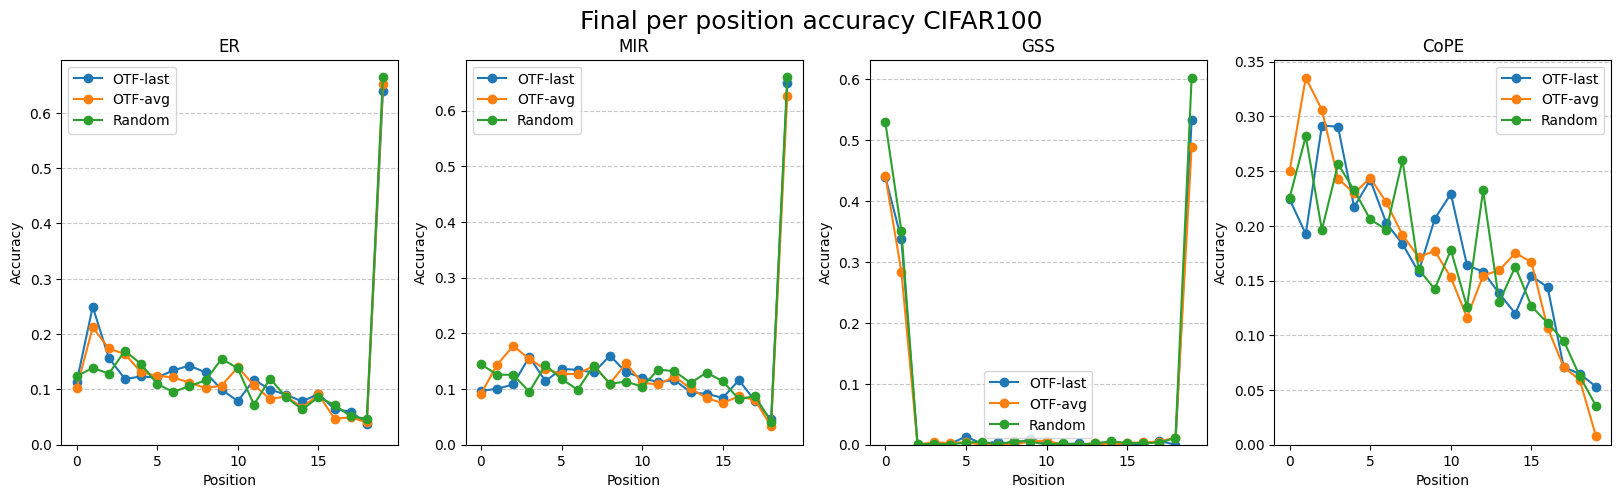

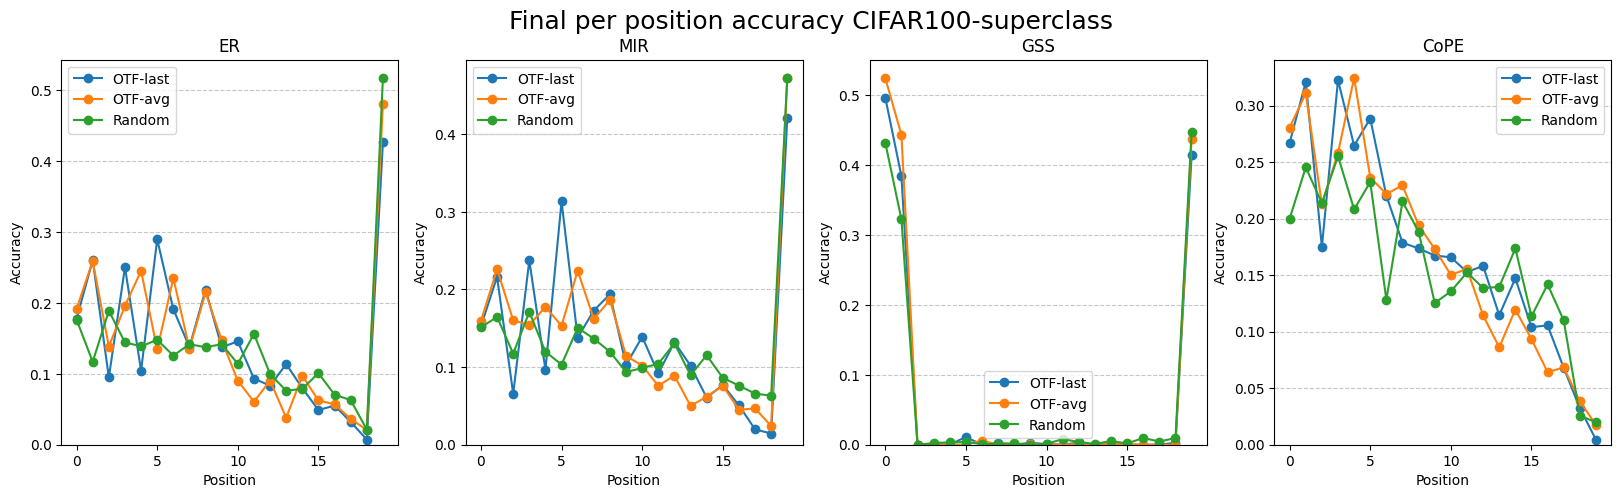

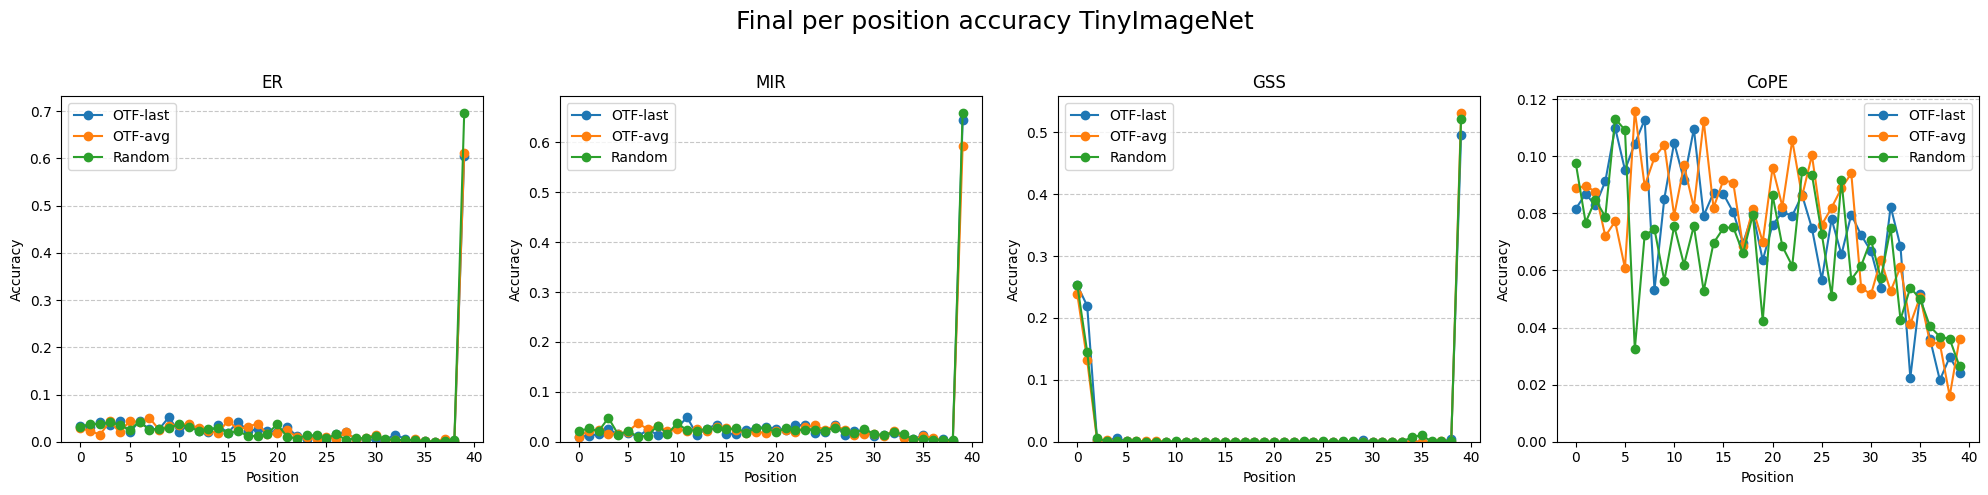

In [14]:
for dataset in longer_datasets:
    fig, axs = plt.subplots(1, len(strategies), figsize=(20, 5))
    fig.suptitle(f"Final per position accuracy {dataset}", fontsize=18)
    
    for row_idx, strategy in enumerate(strategies):
        otf_last_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        otf_avg_cd_results = load_results(dataset, strategy, "on the fly-center-max-true")
        random_cd_results  = load_results(dataset, strategy, "random")
        
        def compute_per_position_performance(results):
            per_position_performance = np.zeros(np.array(results["accuracy per task"]).shape)
            for run_id in range(len(results["ordering"])):
                run_ordering = results["ordering"][run_id]
                for seq_id in range(len(run_ordering)):
                    for position, task in enumerate(run_ordering):
                        per_position_performance[run_id, seq_id, position] = results["accuracy per task"][run_id][seq_id][task]
            return np.mean(per_position_performance, axis=0)

        otf_last_per_position_performance_mean = compute_per_position_performance(otf_last_cd_results)
        otf_avg_per_position_performance_mean = compute_per_position_performance(otf_avg_cd_results)
        random_per_position_performance_mean = compute_per_position_performance(random_cd_results)
        
        otf_last_per_position_performance_mean[otf_last_per_position_performance_mean == -1] = None
        otf_avg_per_position_performance_mean[otf_avg_per_position_performance_mean == -1] = None
        random_per_position_performance_mean[random_per_position_performance_mean == -1] = None

        n_tasks = otf_last_per_position_performance_mean.shape[0]
        x = np.arange(n_tasks)
        width = 0.25

        # Create grouped bar chart
        axs[row_idx].plot(otf_last_per_position_performance_mean[-1], label='OTF-last', marker='o')
        axs[row_idx].plot(otf_avg_per_position_performance_mean[-1], label='OTF-avg', marker='o')
        axs[row_idx].plot(random_per_position_performance_mean[-1], label='Random', marker='o')

        axs[row_idx].set_title(f"{strategy_to_name[strategy]}")
        axs[row_idx].set_xlabel('Position', fontsize=18)
        axs[row_idx].set_ylabel('Accuracy', fontsize=18)
        # axs[row_idx].set_xticks(x)
        # axs[row_idx].set_xticklabels(x)
        axs[row_idx].legend(fontsize=14)
        axs[row_idx].grid(axis='y', linestyle='--', alpha=0.7)
        axs[row_idx].set_ylim(bottom=0)
    plt.savefig(f"results/cd_evaluation/evolution_cd_performance/{dataset}_final_per_position_accuracy_line_plot.png")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

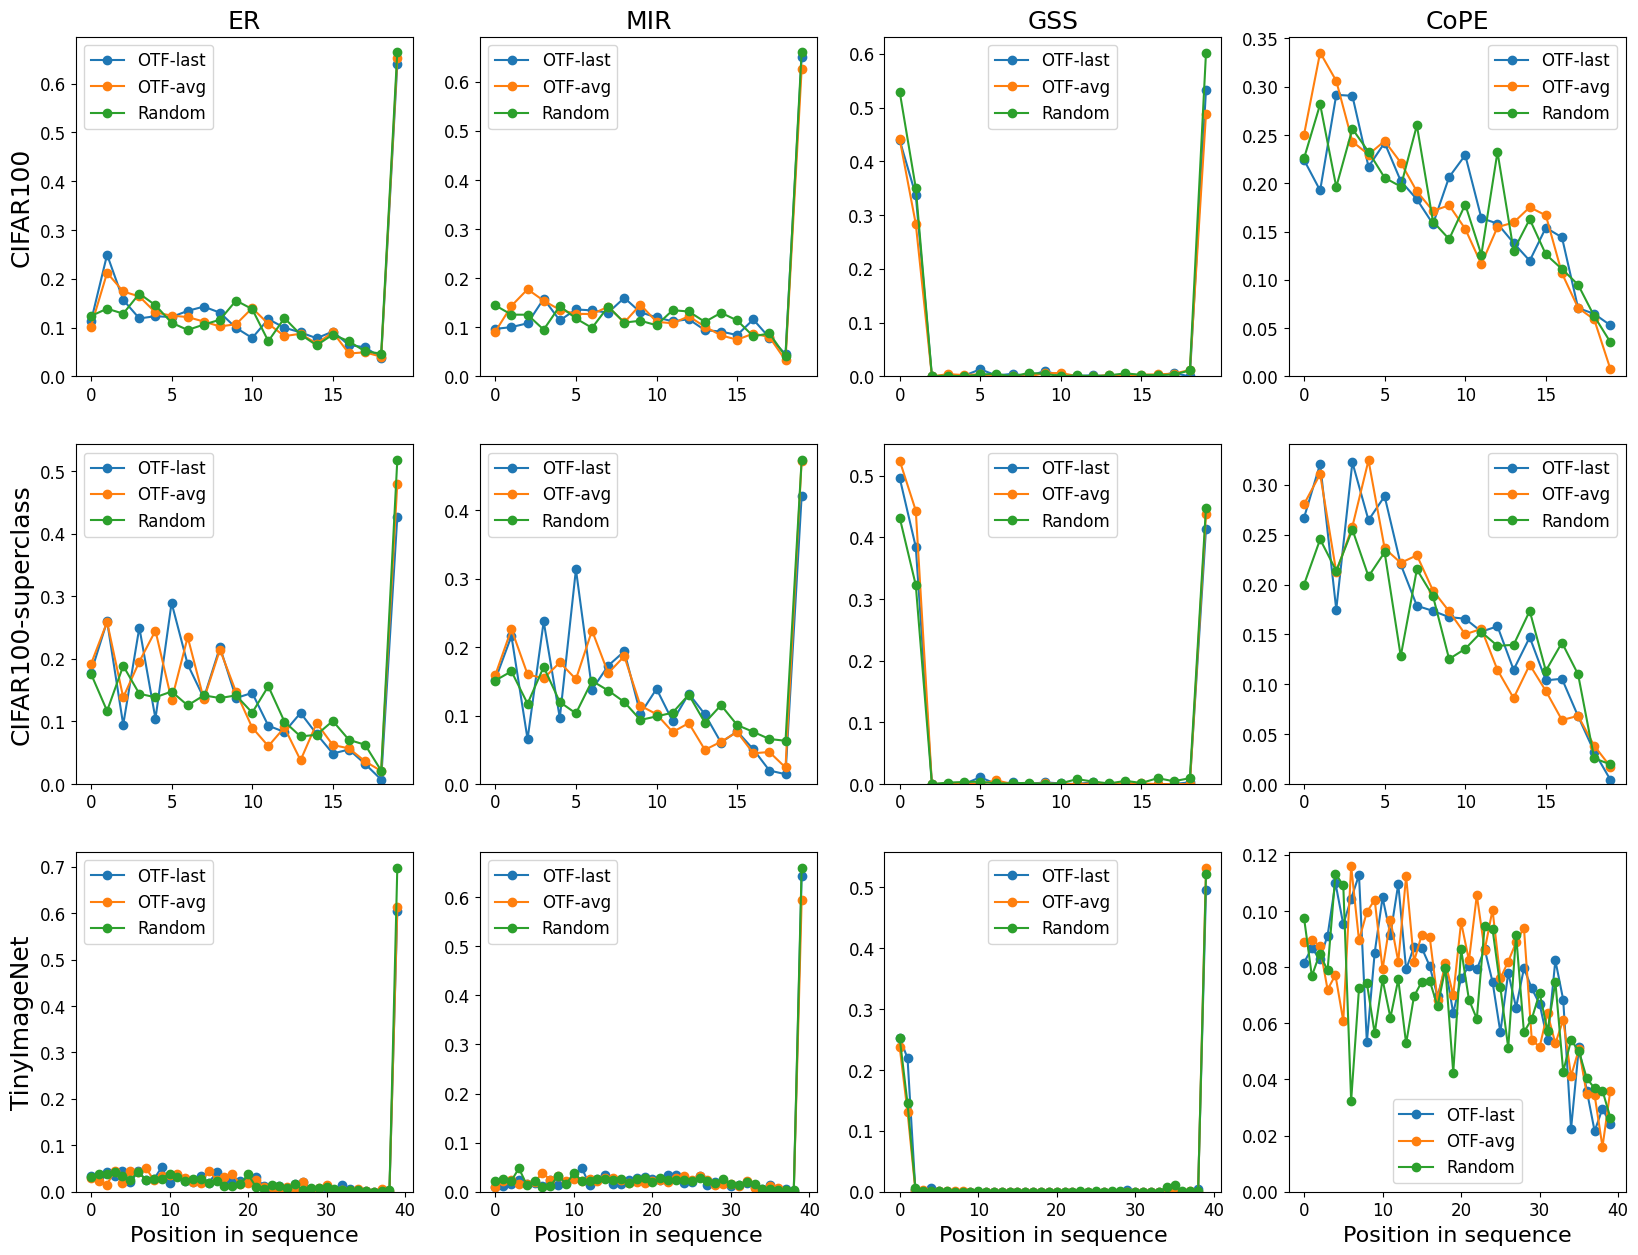

In [34]:
fig, axs = plt.subplots(len(longer_datasets), len(strategies), figsize=(5*len(strategies), 5*len(longer_datasets)))
for row_idx, dataset in enumerate(longer_datasets):
    for col_idx, strategy in enumerate(strategies):
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(strategy_to_name[strategy], fontsize=22)
        if col_idx == 0: 
            axs[row_idx, col_idx].set_ylabel(dataset_to_name[dataset], fontsize=22)
        if row_idx == len(five_task_datasets) - 1: 
            axs[row_idx, col_idx].set_xlabel("Position in sequence", fontsize=16)
        otf_last_cd_results = load_results(dataset, strategy, "on the fly-center-max-false")
        otf_avg_cd_results = load_results(dataset, strategy, "on the fly-center-max-true")
        random_cd_results  = load_results(dataset, strategy, "random")
        
        def compute_per_position_performance(results):
            per_position_performance = np.zeros(np.array(results["accuracy per task"]).shape)
            for run_id in range(len(results["ordering"])):
                run_ordering = results["ordering"][run_id]
                for seq_id in range(len(run_ordering)):
                    for position, task in enumerate(run_ordering):
                        per_position_performance[run_id, seq_id, position] = results["accuracy per task"][run_id][seq_id][task]
            return np.mean(per_position_performance, axis=0)

        otf_last_per_position_performance_mean = compute_per_position_performance(otf_last_cd_results)
        otf_avg_per_position_performance_mean = compute_per_position_performance(otf_avg_cd_results)
        random_per_position_performance_mean = compute_per_position_performance(random_cd_results)
        
        otf_last_per_position_performance_mean[otf_last_per_position_performance_mean == -1] = None
        otf_avg_per_position_performance_mean[otf_avg_per_position_performance_mean == -1] = None
        random_per_position_performance_mean[random_per_position_performance_mean == -1] = None

        n_tasks = otf_last_per_position_performance_mean.shape[0]
        x = np.arange(n_tasks)
        width = 0.25

        # Create grouped bar chart
        axs[row_idx, col_idx].plot(otf_last_per_position_performance_mean[-1], label='OTF-last', marker='o')
        axs[row_idx, col_idx].plot(otf_avg_per_position_performance_mean[-1], label='OTF-avg', marker='o')
        axs[row_idx, col_idx].plot(random_per_position_performance_mean[-1], label='Random', marker='o')

        # axs[row_idx].set_xticks(x)
        # axs[row_idx].set_xticklabels(x)
        if strategy == "gss":
            axs[row_idx, col_idx].legend(loc="upper center", fontsize=12)
        else: 
            axs[row_idx, col_idx].legend(fontsize=12)
        # axs[row_idx, col_idx].grid(axis='y', linestyle='--', alpha=0.7)
        axs[row_idx, col_idx].set_ylim(bottom=0)
        for axes in axs:
            for ax in axes:
                ax.tick_params(axis='both', which='major', labelsize=12)

In [16]:
df_data = []
for dataset in ["CIFAR100-superclass"]:
    for cd in longer_cds:
        for strategy in strategies:
            df_entry = {"Dataset": dataset, "Strategy": strategy, "CD": cd_to_name[cd]}
            print(df_entry)
            orderings = load_results(dataset, strategy, cd)["ordering"]
            for id, ordering in enumerate(orderings):
                df_entry[f"Ordering {id}"] = ordering
            df_data.append(df_entry)
df = pd.DataFrame(df_data)
pd.set_option('display.max_colwidth', None)
df

{'Dataset': 'CIFAR100-superclass', 'Strategy': 'replay', 'CD': 'OTF-last'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'mir', 'CD': 'OTF-last'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'gss', 'CD': 'OTF-last'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'cope', 'CD': 'OTF-last'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'replay', 'CD': 'OTF-avg'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'mir', 'CD': 'OTF-avg'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'gss', 'CD': 'OTF-avg'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'cope', 'CD': 'OTF-avg'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'replay', 'CD': 'Random'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'mir', 'CD': 'Random'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'gss', 'CD': 'Random'}
{'Dataset': 'CIFAR100-superclass', 'Strategy': 'cope', 'CD': 'Random'}


Dataset Strategy        CD  \
0   CIFAR100-superclass   replay  OTF-last   
1   CIFAR100-superclass      mir  OTF-last   
2   CIFAR100-superclass      gss  OTF-last   
3   CIFAR100-superclass     cope  OTF-last   
4   CIFAR100-superclass   replay   OTF-avg   
5   CIFAR100-superclass      mir   OTF-avg   
6   CIFAR100-superclass      gss   OTF-avg   
7   CIFAR100-superclass     cope   OTF-avg   
8   CIFAR100-superclass   replay    Random   
9   CIFAR100-superclass      mir    Random   
10  CIFAR100-superclass      gss    Random   
11  CIFAR100-superclass     cope    Random   

                                                                Ordering 0  \
0   [1, 17, 13, 9, 7, 10, 4, 0, 2, 11, 3, 18, 15, 19, 14, 6, 12, 5, 8, 16]   
1   [1, 9, 13, 17, 15, 10, 12, 19, 2, 0, 4, 11, 5, 7, 14, 18, 3, 8, 6, 16]   
2   [1, 17, 16, 9, 13, 10, 3, 11, 0, 2, 19, 8, 5, 12, 18, 14, 7, 4, 15, 6]   
3   [1, 9, 3, 17, 16, 10, 14, 19, 13, 11, 5, 2, 6, 0, 18, 4, 12, 15, 7, 8]   
4   [1, 17, 3, 13, 9, 7, 11, 10, 2, 0, 14, 4, 19, 12, 18, 8, 6, 5, 16, 15]   
5   [1, 17, 13, 10, 3, 9, 7, 4, 2, 11, 0, 19, 12, 5, 14, 15, 8, 18, 16, 6]   
6   [1, 9, 17, 13, 2, 0, 10, 7, 12, 14, 3, 4, 5, 11, 19, 15, 8, 16, 18, 6]   
7   [1, 17, 3, 10, 2, 9, 4, 0, 7, 13, 5, 18, 8, 12, 14, 11, 16, 6, 19, 15]   
8   [9, 2, 4, 18, 17, 8, 0, 16, 11, 3, 13, 10, 7, 12, 1, 6, 5, 19, 14, 15]   
9   [15, 4, 14, 6, 13, 16, 10, 7, 17, 18, 5, 11, 2, 12, 1, 19, 3, 0, 9, 8]   
10  [12, 14, 18, 1, 5, 19, 15, 13, 16, 17, 10, 2, 9, 7, 3, 4, 6, 11, 0, 8]   
11  [15, 14, 7, 9, 3, 12, 17, 19, 16, 1, 13, 8, 4, 0, 6, 11, 10, 18, 2, 5]   

                                                                Ordering 1  \
0   [1, 17, 13, 9, 15, 10, 7, 11, 3, 2, 0, 5, 8, 19, 4, 18, 12, 6, 16, 14]   
1   [1, 9, 15, 10, 7, 17, 13, 11, 2, 0, 4, 19, 12, 3, 18, 5, 8, 6, 16, 14]   
2   [1, 17, 13, 9, 16, 19, 2, 11, 7, 14, 10, 12, 0, 18, 3, 4, 5, 8, 15, 6]   
3   [1, 17, 0, 3, 10, 5, 9, 13, 2, 19, 4, 11, 7, 14, 15, 18, 16, 6, 12, 8]   
4   [1, 17, 13, 9, 2, 7, 0, 3, 10, 4, 5, 11, 12, 14, 19, 16, 18, 6, 15, 8]   
5   [1, 17, 2, 3, 10, 13, 9, 7, 4, 0, 12, 11, 5, 14, 18, 19, 16, 8, 6, 15]   
6   [1, 17, 13, 9, 12, 15, 10, 19, 5, 2, 7, 0, 3, 4, 14, 18, 6, 11, 8, 16]   
7   [1, 9, 14, 13, 10, 17, 7, 12, 0, 11, 2, 3, 4, 6, 19, 8, 18, 16, 5, 15]   
8   [4, 3, 17, 1, 2, 5, 12, 11, 19, 10, 6, 18, 9, 14, 15, 0, 7, 13, 16, 8]   
9   [9, 0, 7, 8, 11, 2, 3, 13, 10, 16, 18, 5, 17, 15, 12, 19, 1, 4, 14, 6]   
10  [7, 0, 6, 18, 16, 3, 15, 10, 8, 14, 1, 12, 19, 17, 13, 11, 9, 2, 4, 5]   
11  [1, 3, 10, 9, 15, 19, 13, 0, 2, 17, 6, 8, 18, 5, 4, 11, 14, 12, 16, 7]   

                                                                Ordering 2  \
0   [1, 17, 13, 9, 12, 10, 4, 11, 2, 0, 3, 18, 6, 7, 5, 8, 19, 16, 14, 15]   
1   [1, 9, 13, 17, 15, 10, 4, 19, 2, 11, 3, 0, 5, 7, 6, 12, 18, 16, 14, 8]   
2   [1, 17, 2, 19, 12, 9, 14, 10, 5, 0, 11, 13, 18, 3, 4, 7, 8, 15, 6, 16]   
3   [1, 17, 3, 10, 2, 9, 13, 11, 4, 0, 14, 18, 7, 19, 12, 6, 5, 8, 15, 16]   
4   [1, 2, 9, 13, 17, 7, 10, 4, 0, 5, 11, 3, 14, 8, 19, 12, 18, 6, 15, 16]   
5   [1, 9, 17, 13, 3, 7, 2, 10, 4, 0, 18, 12, 5, 19, 11, 8, 14, 6, 16, 15]   
6   [1, 17, 13, 9, 14, 7, 10, 2, 5, 8, 0, 4, 12, 3, 11, 15, 19, 16, 18, 6]   
7   [1, 17, 2, 3, 7, 9, 13, 11, 10, 0, 12, 4, 15, 14, 19, 8, 5, 6, 18, 16]   
8   [15, 7, 5, 16, 13, 1, 10, 19, 14, 12, 9, 4, 11, 17, 0, 18, 6, 8, 2, 3]   
9   [4, 13, 18, 2, 14, 7, 19, 10, 3, 8, 6, 11, 9, 12, 5, 16, 0, 15, 1, 17]   
10  [12, 1, 7, 2, 19, 6, 10, 14, 0, 3, 16, 11, 15, 18, 8, 9, 17, 4, 5, 13]   
11  [16, 1, 15, 18, 9, 10, 5, 7, 11, 3, 8, 12, 13, 17, 0, 14, 2, 19, 4, 6]   

                                                                Ordering 3  \
0   [1, 9, 15, 17, 12, 10, 4, 3, 11, 0, 2, 19, 13, 18, 7, 14, 6, 8, 5, 16]   
1   [1, 17, 13, 9, 3, 10, 7, 2, 11, 4, 0, 14, 19, 12, 6, 15, 18, 16, 5, 8]   
2   [1, 9, 13, 17, 2, 19, 8, 10, 16, 11, 0, 18, 3, 12, 4, 5, 7, 14, 15, 6]   
3   [1, 17, 3, 12, 10, 4, 9, 7, 11, 2, 6, 0, 18, 15, 19, 13,

## 3. Stability of task orders from OTF-cds

### 5-task setttings

#### Within methods

In [17]:
df_data = []
for dataset in five_task_datasets:
    for cd in longer_cds:
        for strategy in strategies:
            distances = []
            orderings = load_results(dataset, strategy, cd)["ordering"]
            for id, ordering in enumerate(orderings):
                for ordering2 in orderings[id + 1:]:
                    distances.append(spearman_footrule_distance(ordering, ordering2))
            df_data.append({"Dataset":dataset_to_name[dataset], "Strategy": strategy_to_name[strategy], "CD": cd_to_name[cd], "Mean Footrule distance between orderings": np.mean(distances)})
df_footrule_within = pd.DataFrame(df_data).round(3)
pd.set_option('display.max_rows', None)
df_footrule_within = df_footrule_within.groupby(["Dataset", "Strategy", "CD"]).mean()
df_footrule_within.to_csv("results/cd_evaluation/task_order_stability/5task_stability_within.csv")

#### Between methods

In [18]:
df_data = []
for dataset in five_task_datasets:
    for cd in longer_cds:
        for id, strategy in enumerate(strategies):
            for strategy2 in strategies[id:]:
                distances = []
                strat1_orderings = load_results(dataset, strategy, cd)["ordering"]
                strat2_orderings = load_results(dataset, strategy2, cd)["ordering"]
                for idx1, ordering in enumerate(strat1_orderings):
                    for idx2, ordering2 in enumerate(strat2_orderings):
                        if not (idx1 == idx2 and strategy == strategy2):
                            distances.append(spearman_footrule_distance(ordering, ordering2))
                        else:
                            pass
                df_data.append({"Dataset":dataset_to_name[dataset], "CD": cd_to_name[cd], "Strategy 1": strategy_to_name[strategy], "Strategy 2": strategy_to_name[strategy2], "Mean Footrule distance": np.mean(distances)})
df_footrule_between_pairwise = pd.DataFrame(df_data).round(3)
df_footrule_between_pairwise = df_footrule_between_pairwise.groupby(["Dataset", "CD", "Strategy 1", "Strategy 2"]).mean().round(3)
df_footrule_between_pairwise.to_csv("results/cd_evaluation/task_order_stability/5task_stability_between.csv")

### Longer settings

#### Within methods

In [19]:
df_data = []
for dataset in longer_datasets:
    for cd in longer_cds:
        for strategy in strategies:
            distances = []
            orderings = load_results(dataset, strategy, cd)["ordering"]
            for id, ordering in enumerate(orderings):
                for ordering2 in orderings[id + 1:]:
                    distances.append(spearman_footrule_distance(ordering, ordering2))
            df_data.append({"Dataset":dataset_to_name[dataset], "Strategy": strategy_to_name[strategy], "CD": cd_to_name[cd], "Mean Footrule distance between orderings": np.mean(distances)})
df_footrule_within = pd.DataFrame(df_data).round(3)
pd.set_option('display.max_rows', None)
df_footrule_within = df_footrule_within.groupby(["Dataset", "Strategy", "CD"]).mean()
df_footrule_within.to_csv("results/cd_evaluation/task_order_stability/longer-datasets_stability_within.csv")

#### Between methods

In [20]:
df_data = []
for dataset in longer_datasets:
    for cd in longer_cds:
        for id, strategy in enumerate(strategies):
            for strategy2 in strategies[id:]:
                distances = []
                strat1_orderings = load_results(dataset, strategy, cd)["ordering"]
                strat2_orderings = load_results(dataset, strategy2, cd)["ordering"]
                for idx1, ordering in enumerate(strat1_orderings):
                    for idx2, ordering2 in enumerate(strat2_orderings):
                        if not (idx1 == idx2 and strategy == strategy2):
                            distances.append(spearman_footrule_distance(ordering, ordering2))
                        else:
                            pass
                df_data.append({"Dataset":dataset_to_name[dataset], "CD": cd_to_name[cd], "Strategy 1": strategy_to_name[strategy], "Strategy 2": strategy_to_name[strategy2], "Mean Footrule distance": np.mean(distances)})
df_footrule_between_pairwise = pd.DataFrame(df_data).round(3)
df_footrule_between_pairwise = df_footrule_between_pairwise.groupby(["Dataset", "CD", "Strategy 1", "Strategy 2"]).mean().round(3)
df_footrule_between_pairwise.to_csv("results/cd_evaluation/task_order_stability/longer-datasets_stability_between.csv")